In [3]:
import re
import datetime
import json
import pandas as pd
import numpy as np
import operator
import warnings
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
from scipy.spatial import distance
from itertools import combinations

import networkx as nx
from networkx import betweenness_centrality 
from networkx import closeness_centrality
from networkx import degree_centrality

import community
from community import modularity
from community import generate_dendrogram

## Functions

In [4]:
def find_gc(network):
    '''
    Find the network giant component
    '''
    gc_nodes = max(nx.connected_components(network), key=len)
    network_gc = network.subgraph(gc_nodes).copy()
    return network_gc

In [5]:
def take_edges(suc_authors):
    '''
    Create author nodes and collaboration edges
    '''
    for i in suc_authors:
        for name in i:
            if name == '':
                i.remove('')
    
    edges = []
    nodes = []
    
    for i in suc_authors:
        if len(i) > 1:
            edges.extend(list(combinations(i,2)))
        else:
            nodes.append(i[0].strip())
            
    for pair in edges:
        if pair[0] == pair[1]:
            edges.remove(pair)
    
    return edges, list(set(nodes))

## Import Data (Individual SUCs)

In [6]:
df_rp = pd.read_excel('research_profile.xlsx')

In [7]:
suc_list = [('Abra State Institute of Science and Technology', 'ASSIST'),
            ('Agusan del Sur State College of Agriculture and Technology', 'ASCAT'),
            ('Benguet State University', 'BSU'), 
            ('Bulacan State University', 'BulSU'),
            ('Davao del Norte State College', 'DNSC'),
            ('Mindoro State University', 'MinSU'),
            ('Palawan State University', 'PSU'),
            ('Tarlac State University', 'TSU'),
            ('University of the Philippines Baguio', 'UPB'),  
            ('Romblon State University', 'RSU'),
            ('Quirino State University', 'QSU')]

## Import Data (Author-Topic)

In [8]:
df_topics = pd.read_csv('title_topic.csv')
df_topics = df_topics[df_topics['Topic Name'].notna()]
df_topics = df_topics.reset_index(drop=True)

In [9]:
#topic nodes

topic = df_topics['Topic Name'].copy().str.split(';')
topic = ['None' if x is np.nan else x for x in topic]
topic = [x[0] for x in topic]

topic_nodes = list(set(topic))

In [10]:
#author nodes

authors = df_topics['Author'].copy().str.split(';')
authors = [x for x in authors]

author_nodes = []

for list_ in authors:
    for name in list_:
        author_nodes.append(name.strip())
        
author_nodes = set(author_nodes)
author_nodes.remove('')

In [11]:
#build edges

edges = []

for i in range(len(topic)):
    for name in authors[i]:
        if name == '':
            pass
        else:
            edges.append((name.strip(), topic[i]))

In [12]:
#build network

G = nx.Graph()

G.add_nodes_from(author_nodes)
G.add_nodes_from(topic_nodes)
G.add_edges_from(edges)

In [13]:
#conectivity check

nx.is_connected(G)

True

In [14]:
top = nx.bipartite.sets(G)[0]
aut = nx.bipartite_layout(G, top)

In [15]:
#build projected networks

A = nx.bipartite.projected_graph(G, aut, multigraph=False)
T = nx.bipartite.projected_graph(G, top, multigraph=False)

## Plots

In [17]:
def network_plots(network, school ='test'):
    '''
    Create network plots for individual SUCs
    '''
    N = network.order()
    L = network.size() 
    
    avg_deg = 2*float(L) / N 
    
    degrees = [k for node, k in nx.degree(network)]
    k_min = np.min(degrees)
    k_max = np.max(degrees)
    k_avg = np.mean(degrees)
    
    components = nx.number_connected_components(network)
    
    p, k = np.histogram([k for n,k in nx.degree(network)], bins = (k_max - k_min + 1));
    plt.figure()
    plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
    plt.bar(k[1:],p, color='darkgreen');
    plt.title('Degree Distribution');
    plt.savefig(school + '_degree.png');
    
    pos = nx.spring_layout(network);
    
    plt.figure(figsize=(15, 15));
    plt.axis("off");
    plt.title(school + ' Network', fontsize=10)
    nx.draw_networkx_nodes(network, pos, node_size=10, node_color="darkgreen");
    nx.draw_networkx_edges(network, pos, alpha=0.800, edge_color='darkgrey');
    plt.savefig(school + '.png');
    
    if N/components > 4:
        
        network0 = find_gc(network)
        
        N = network0.order()
        L = network0.size() 
        
        avg_deg = 2*float(L) / N 
        
        degrees = [k for node, k in nx.degree(network0)]
        k_min = np.min(degrees)
        k_max = np.max(degrees)
        k_avg = np.mean(degrees)
    
        plt.figure()
        p, k = np.histogram([k for n,k in nx.degree(network0)], bins = (k_max - k_min + 1));
        plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
        plt.bar(k[1:],p, color='darkgreen');
        plt.title('Degree Distribution')
        plt.savefig(school + '_gc_degree.png');
            
        pos = nx.spring_layout(network0);
        
        plt.figure(figsize=(15, 15));
        plt.axis("off");
        plt.title(school + ' Giant Component Network', fontsize=10)
        nx.draw_networkx_nodes(network0, pos, node_size=100, node_color="darkgreen");
        nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='darkgrey');
        plt.savefig(school + '_gc.png');
        
        sp = nx.average_shortest_path_length(network0)
        
        centralities = [list(nx.degree_centrality(network0).values()), 
                        list(nx.closeness_centrality(network0).values()), 
                        list(nx.betweenness_centrality(network0).values())]
        
        titles = ['DC', 'CC', 'BC']
        filename = ['_dc', '_cc', '_bc']
        
        for i in range(3):
            plt.figure(figsize=(20, 15));
            plt.axis("off");
            plt.title(school + ' ' + titles[i] + ' Network', fontsize=10)
            nc = nx.draw_networkx_nodes(network0, pos, node_size=100, cmap=plt.cm.viridis,
                                        node_color=centralities[i]);
            nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='gray');
            plt.colorbar(nc, shrink=0.5);
            plt.savefig(school + filename[i] + '.png')
        
        if sp > 3:
                partition_mod = community.best_partition(network0)
                pos = nx.spring_layout(network0);
    
                plt.figure(figsize=(15, 15));
                plt.axis("off");
                plt.title(school + ' Modularity Network', fontsize=10)
        
                nx.draw_networkx_nodes(network0, pos, cmap=plt.cm.viridis, node_size=100, node_color=list(partition_mod.values()))
                nx.draw_networkx_edges(network0, pos, alpha=0.8)
                nx.draw_networkx_labels(network0, pos, font_color='grey')
                plt.savefig(school + '_communities.png')
        else:
            pass

    else:
        pass

In [18]:
def bipart_network_plots(network, school ='test'):
    '''
    Create network plots for author-topic bipartite network
    '''
    N = network.order()
    L = network.size() 
    
    avg_deg = 2*float(L) / N 
    
    degrees = [k for node, k in nx.degree(network)]
    k_min = np.min(degrees)
    k_max = np.max(degrees)
    k_avg = np.mean(degrees)
    
    components = nx.number_connected_components(network)
    
    p, k = np.histogram([k for n,k in nx.degree(network)], bins = (k_max - k_min + 1));
    plt.figure()
    plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
    plt.bar(k[1:],p, color='darkgreen');
    plt.title('Degree Distribution');
    plt.savefig(school + '_degree.png');
    
    pos = nx.spring_layout(network);
    
    plt.figure(figsize=(15, 15));
    plt.axis("off");
    plt.title(school + ' Network', fontsize=10)
    nx.draw_networkx_nodes(network, pos, node_size=10, node_color="darkgreen");
    nx.draw_networkx_edges(network, pos, alpha=0.800, edge_color='darkgrey');
    plt.savefig(school + '.png');
    
    if N/components > 4:
        
        network0 = find_gc(network)
        
        N = network0.order()
        L = network0.size() 
        
        avg_deg = 2*float(L) / N 
        
        degrees = [k for node, k in nx.degree(network0)]
        k_min = np.min(degrees)
        k_max = np.max(degrees)
        k_avg = np.mean(degrees)
    
        plt.figure()
        p, k = np.histogram([k for n,k in nx.degree(network0)], bins = (k_max - k_min + 1));
        plt.axvline(avg_deg, color='gold', linestyle='dashed', label='Average Degree')
        plt.bar(k[1:],p, color='darkgreen');
        plt.title('Degree Distribution')
        plt.savefig(school + '_gc_degree.png');
            
        pos = nx.spring_layout(network0);
        
        plt.figure(figsize=(15, 15));
        plt.axis("off");
        plt.title(school + ' Giant Component Network', fontsize=10)
        nx.draw_networkx_nodes(network0, pos, node_size=100, node_color="darkgreen");
        nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='darkgrey');
        plt.savefig(school + '_gc.png');
        
        sp = nx.average_shortest_path_length(network0)
        
        centralities = [list(nx.degree_centrality(network0).values()), 
                        list(nx.closeness_centrality(network0).values()), 
                        list(nx.betweenness_centrality(network0).values())]
        
        titles = ['DC', 'CC', 'BC']
        filename = ['_dc', '_cc', '_bc']
        
        for i in range(3):
            plt.figure(figsize=(20, 15));
            plt.axis("off");
            plt.title(school + ' ' + titles[i] + ' Network', fontsize=10)
            nc = nx.draw_networkx_nodes(network0, pos, node_size=100, cmap=plt.cm.viridis,
                                        node_color=centralities[i]);
            nx.draw_networkx_edges(network0, pos, alpha=0.800, edge_color='gray');
            plt.colorbar(nc, shrink=0.5);
            plt.savefig(school + filename[i] + '.png')
        
        if sp > 1:
                partition_mod = community.best_partition(network0)
                pos = nx.spring_layout(network0);
    
                plt.figure(figsize=(15, 15));
                plt.axis("off");
                plt.title(school + ' Modularity Network', fontsize=10)
        
                nx.draw_networkx_nodes(network0, pos, cmap=plt.cm.viridis, node_size=100, node_color=list(partition_mod.values()))
                nx.draw_networkx_edges(network0, pos, alpha=0.8)
                nx.draw_networkx_labels(network0, pos, font_color='grey')
                plt.savefig(school + '_communities.png')
        else:
            pass

    else:
        pass

/tmp/ipykernel_440/4141468306.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


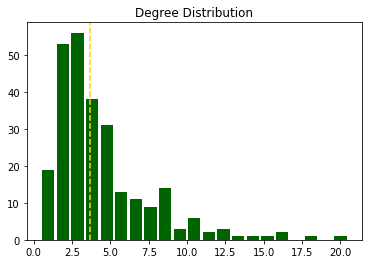

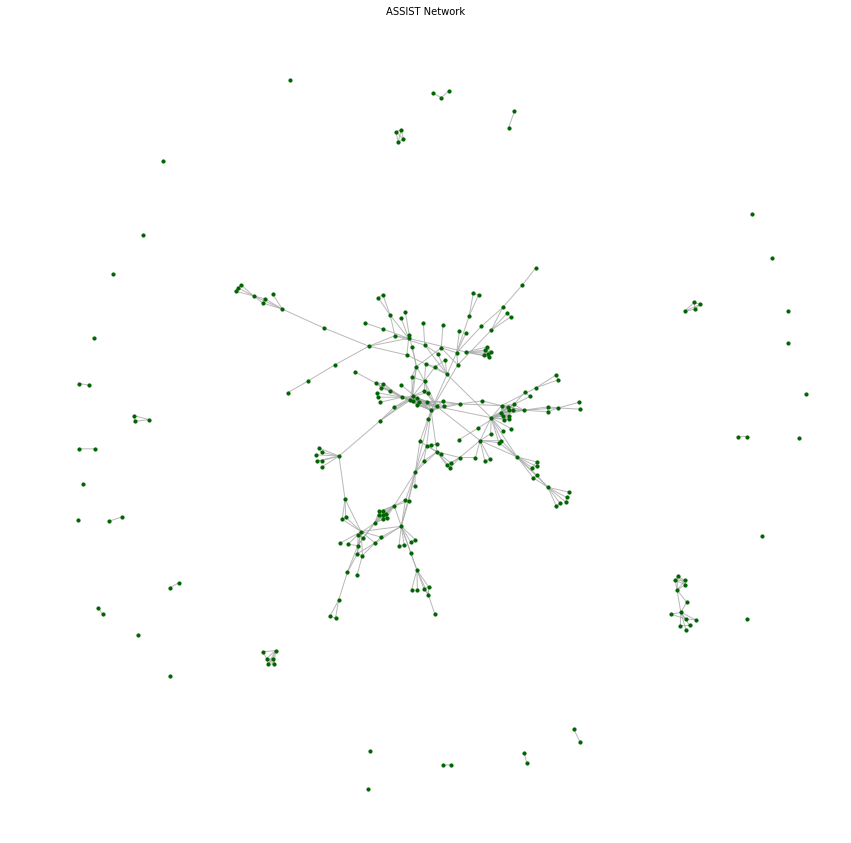

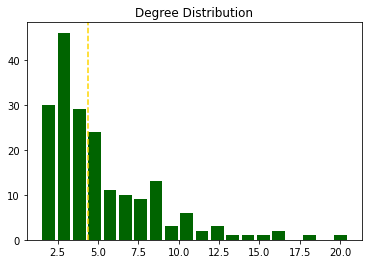

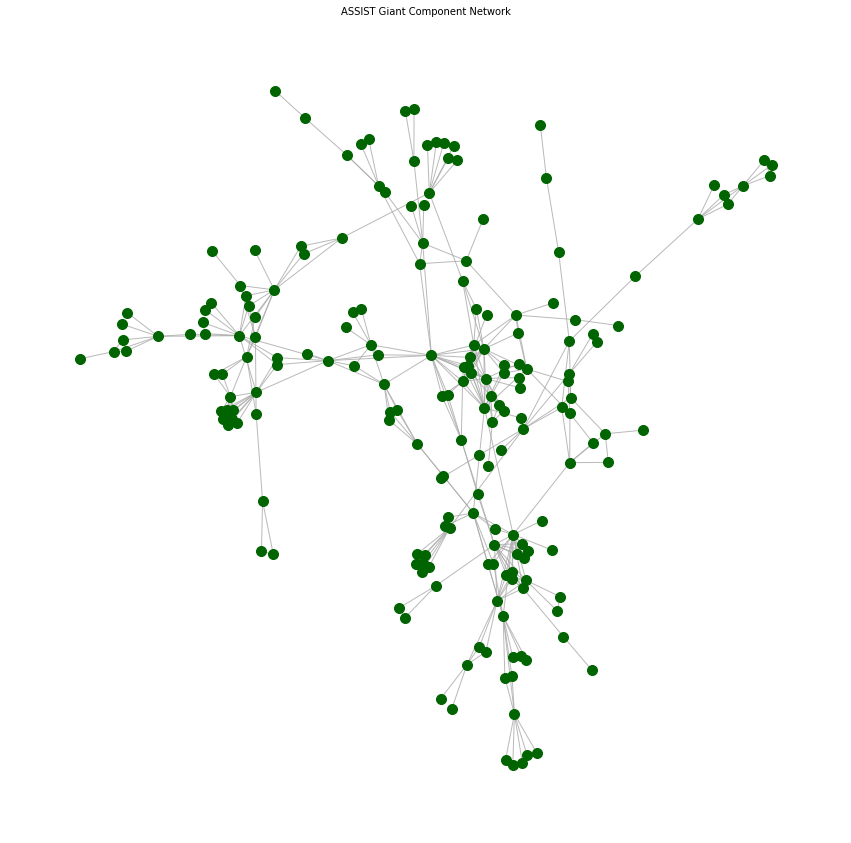

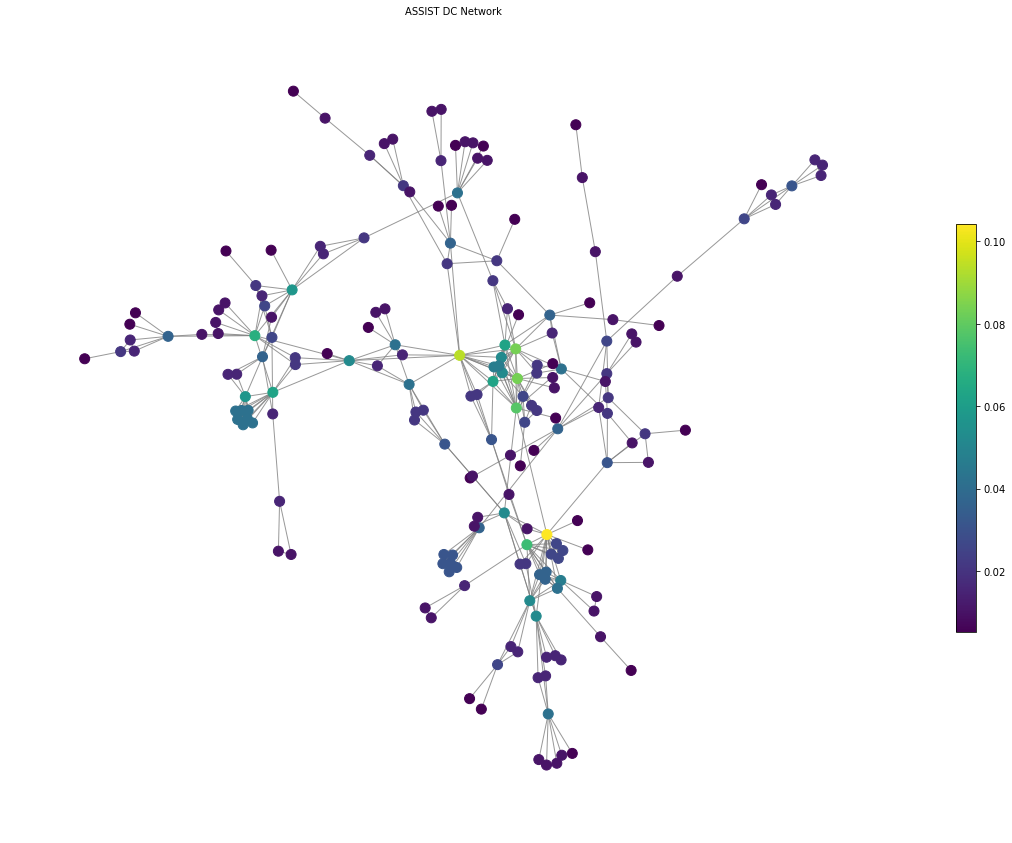

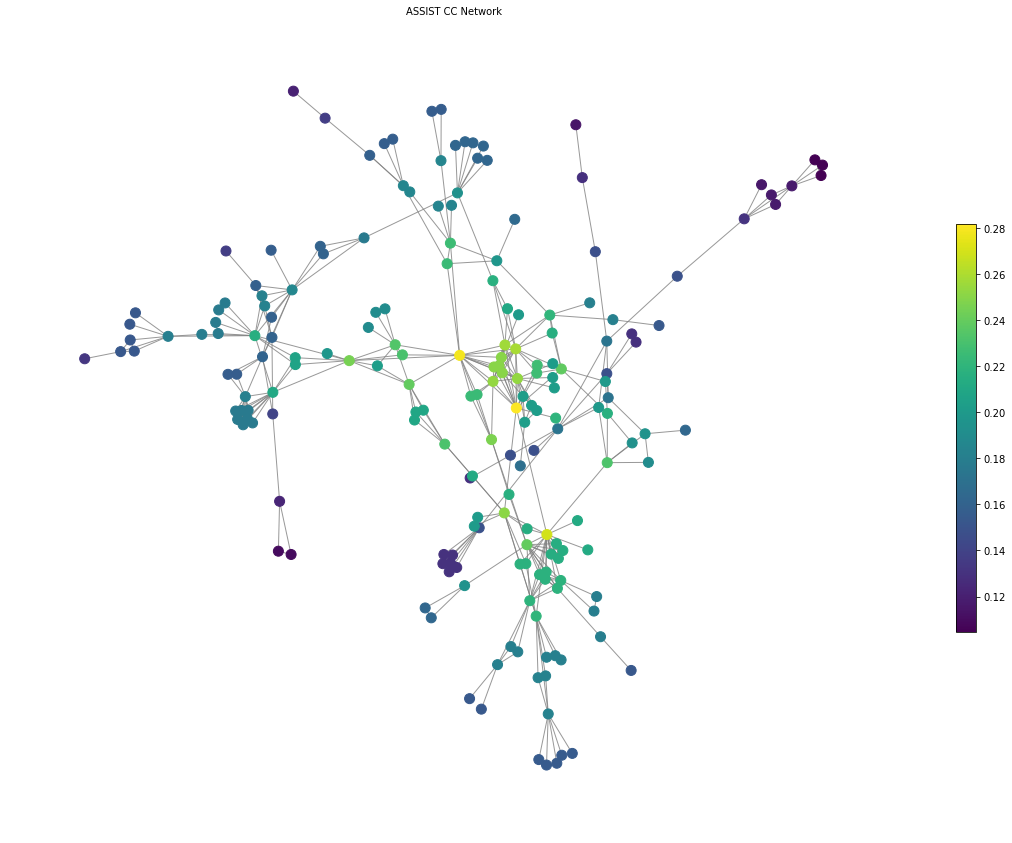

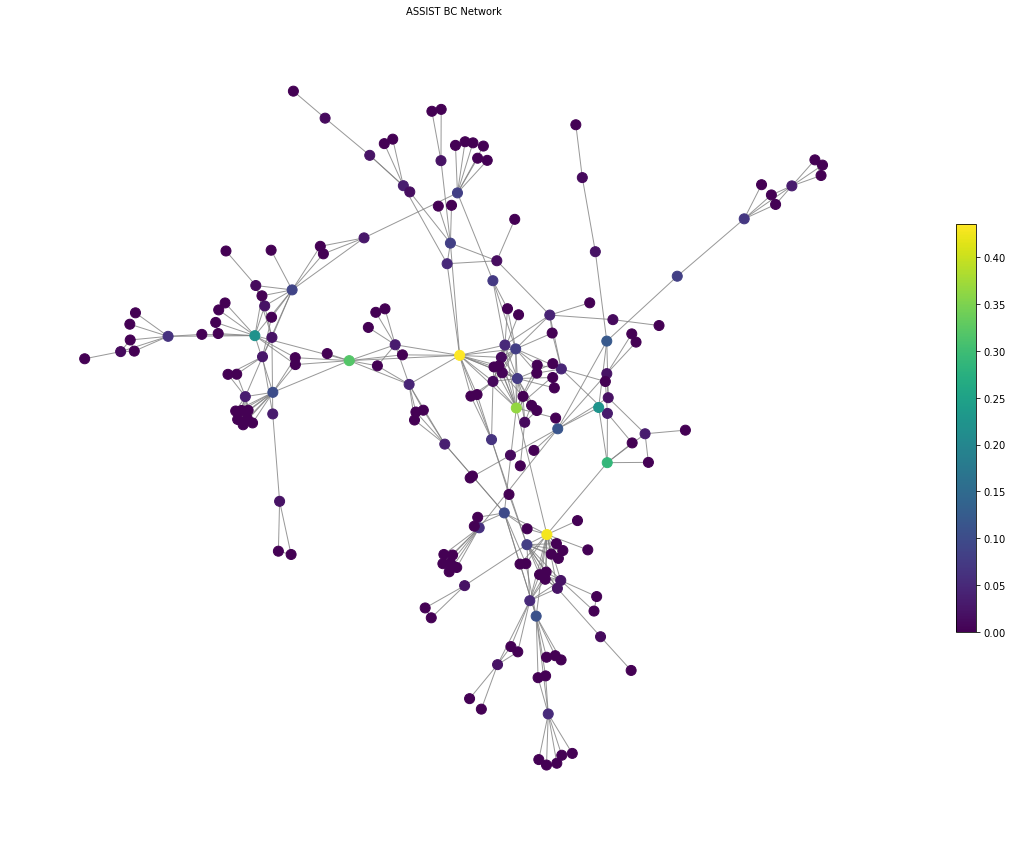

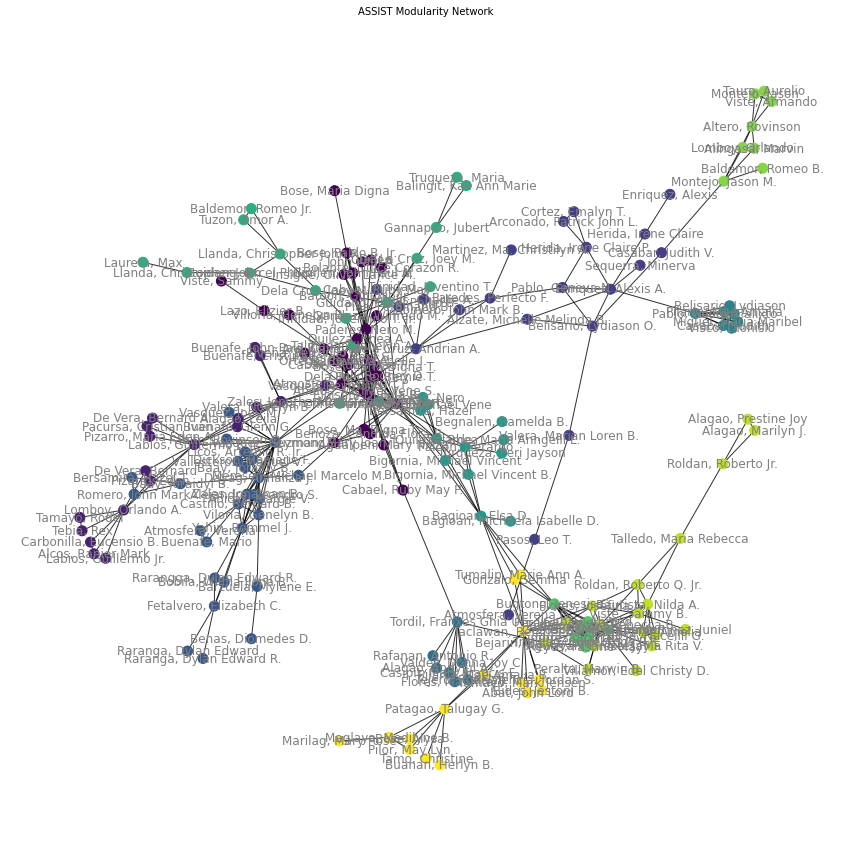

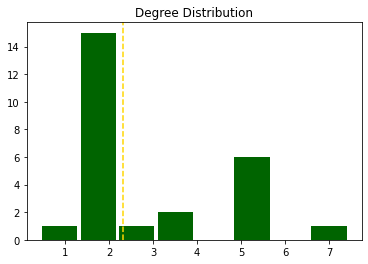

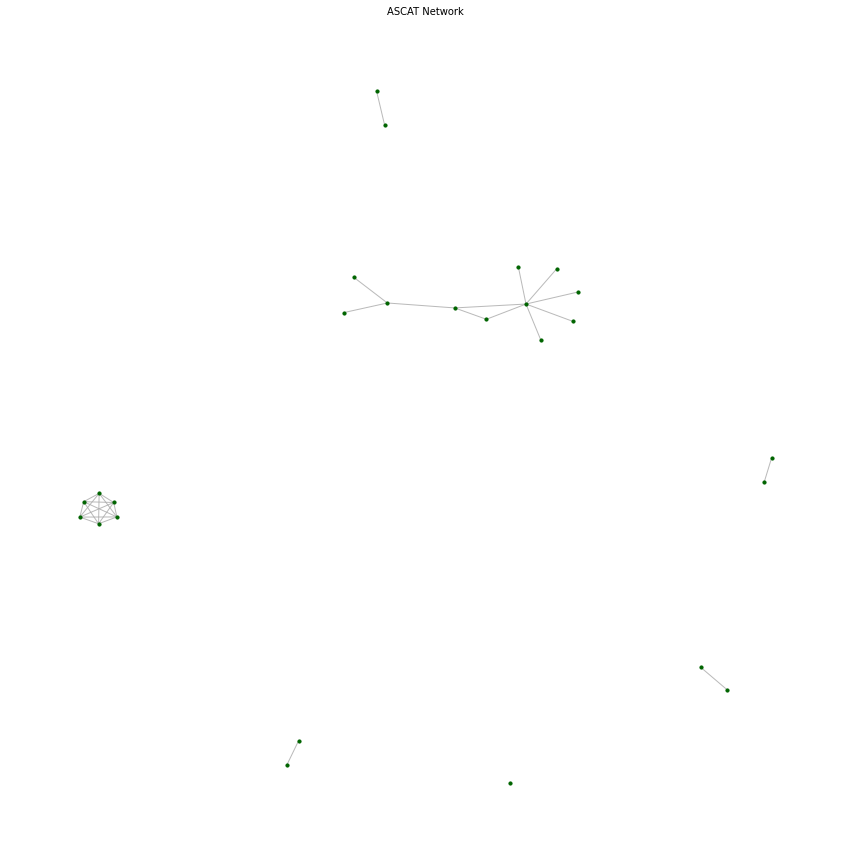

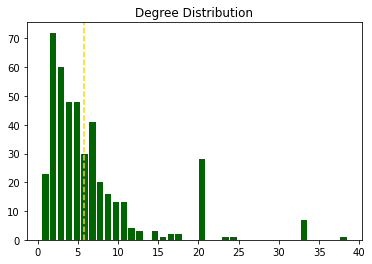

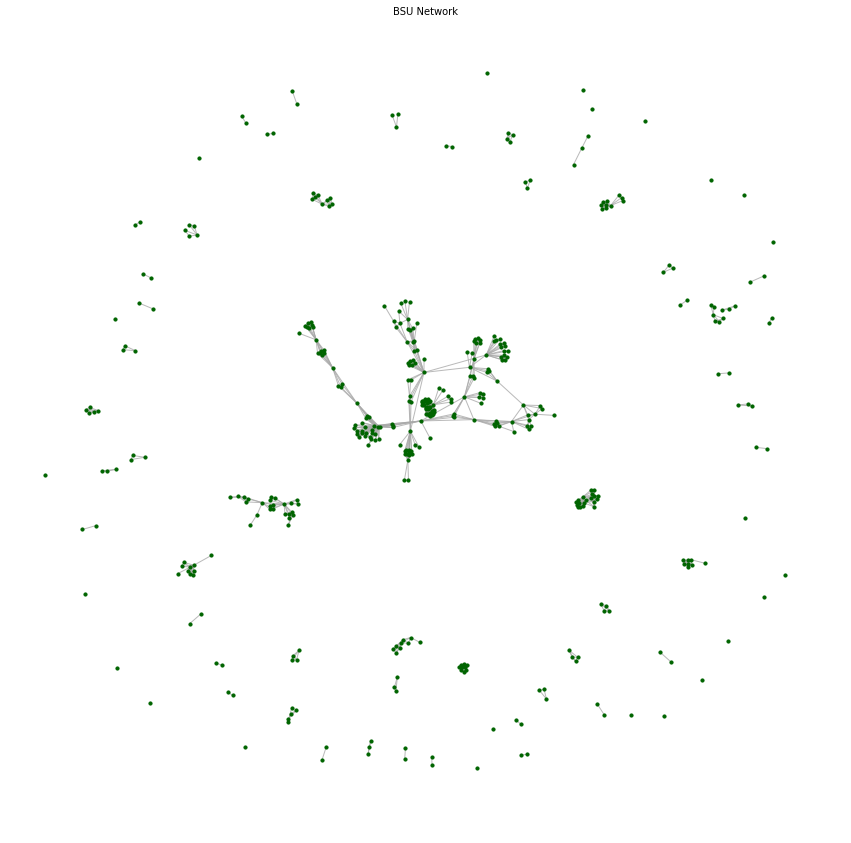

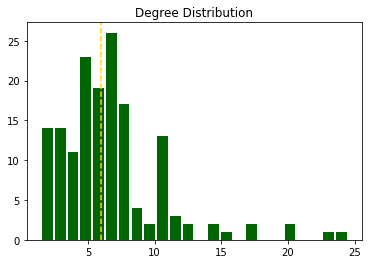

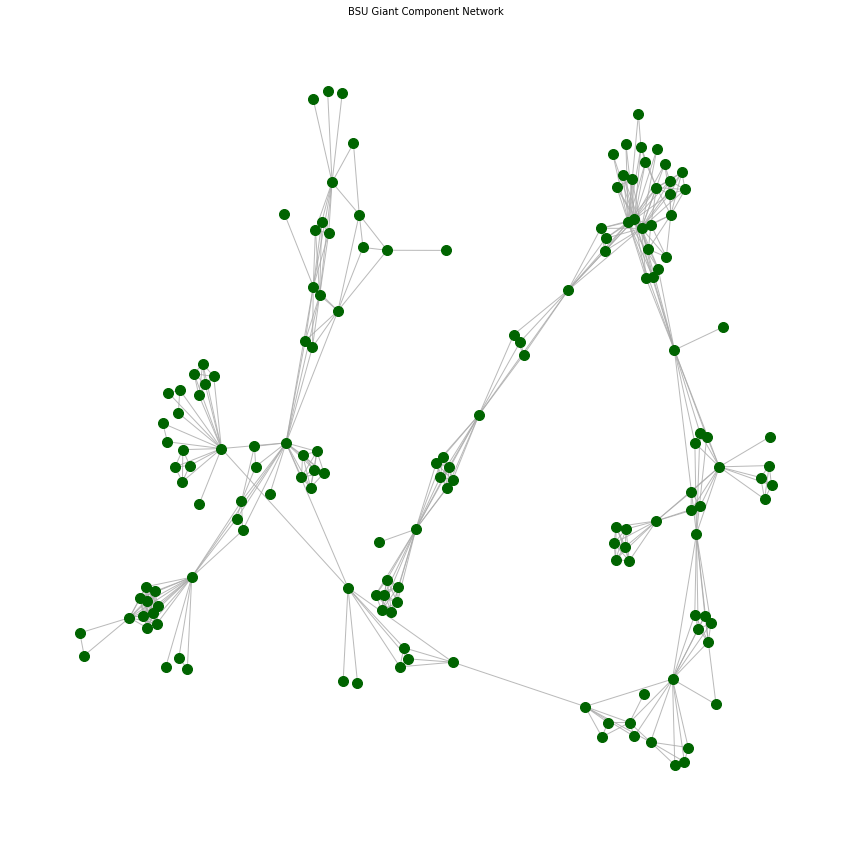

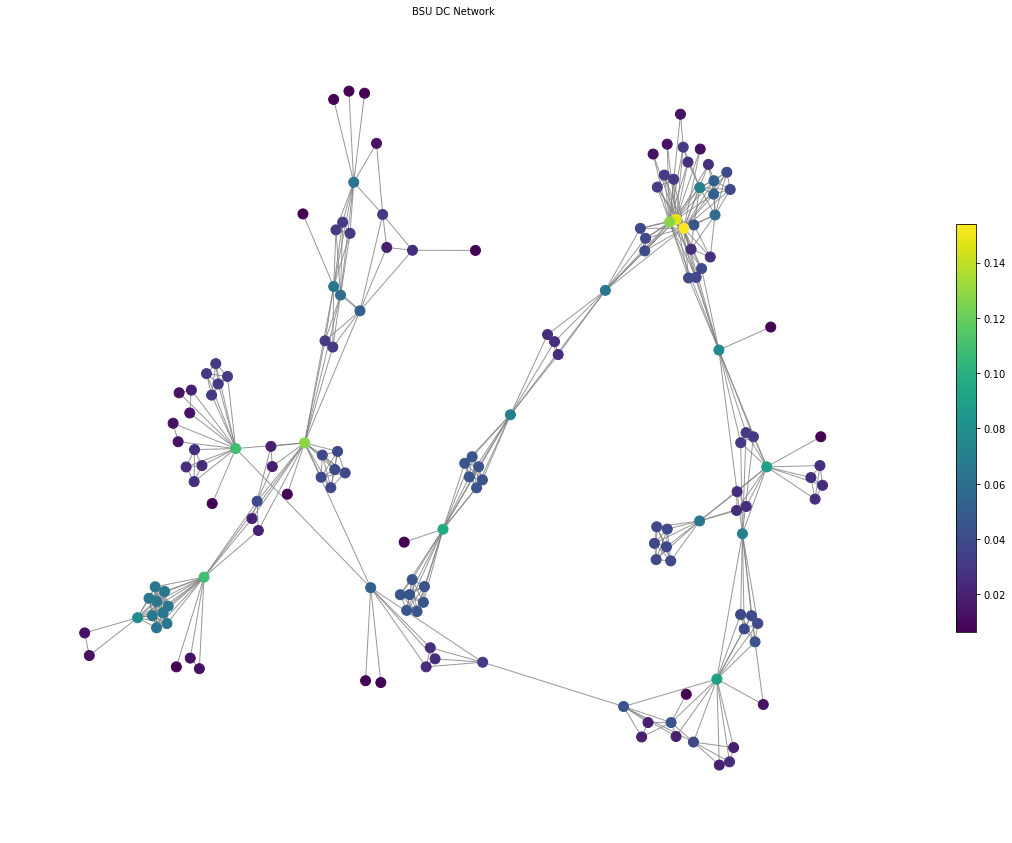

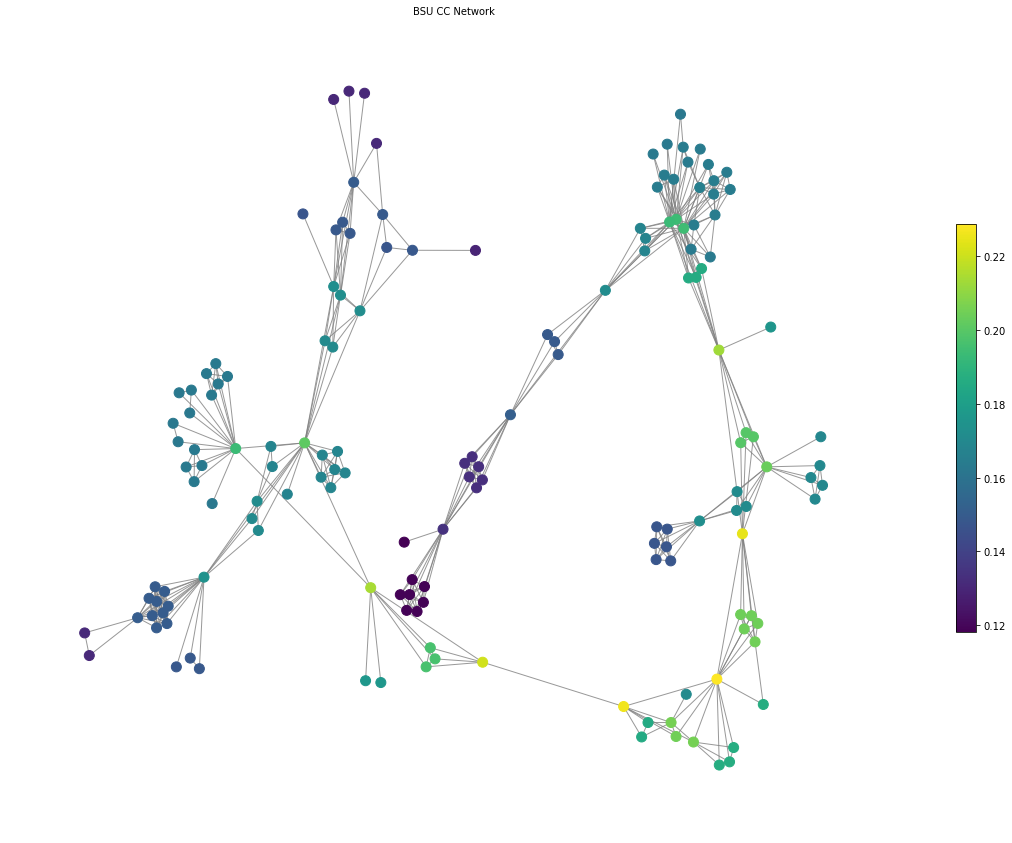

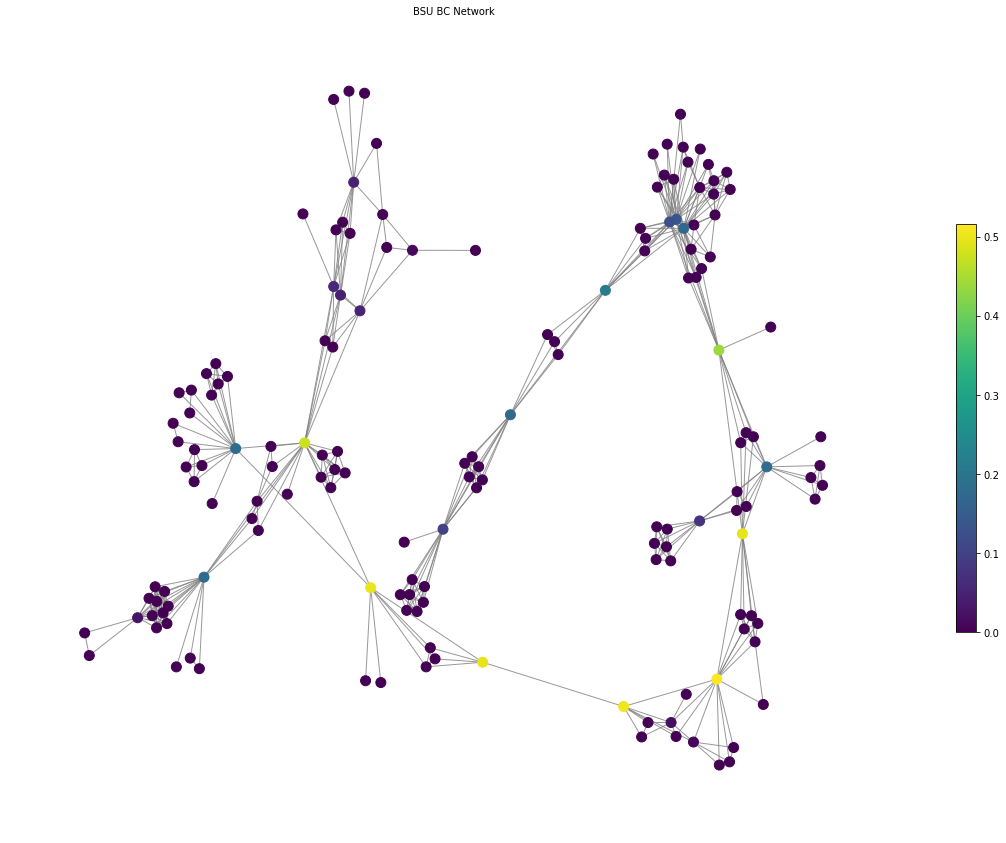

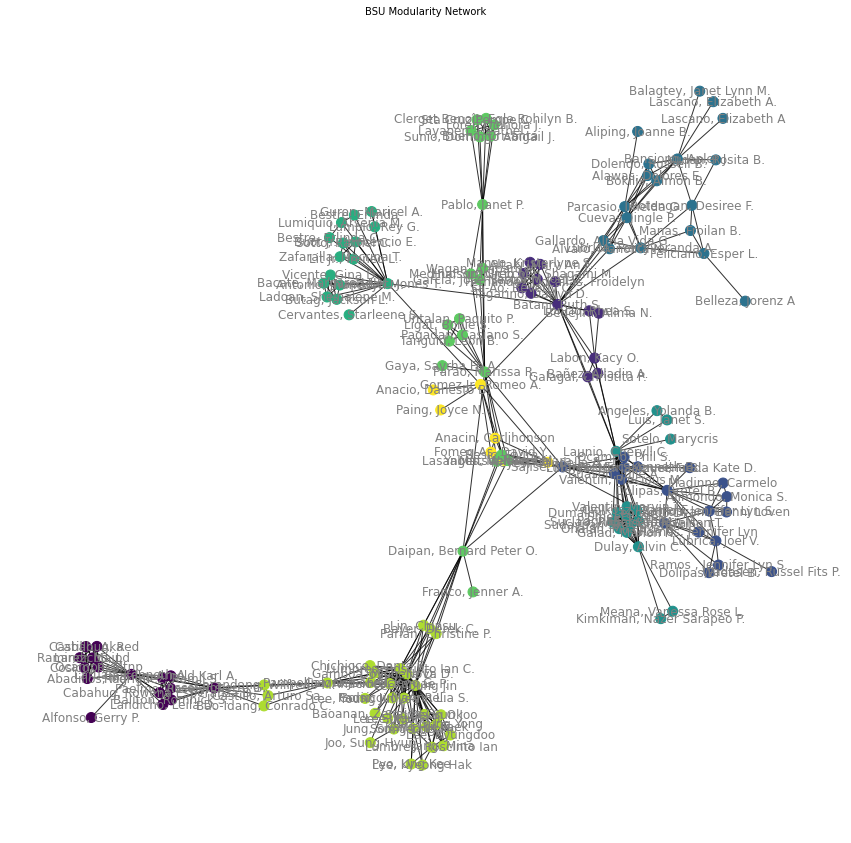

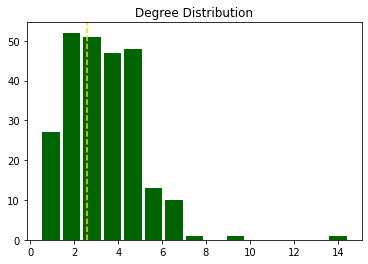

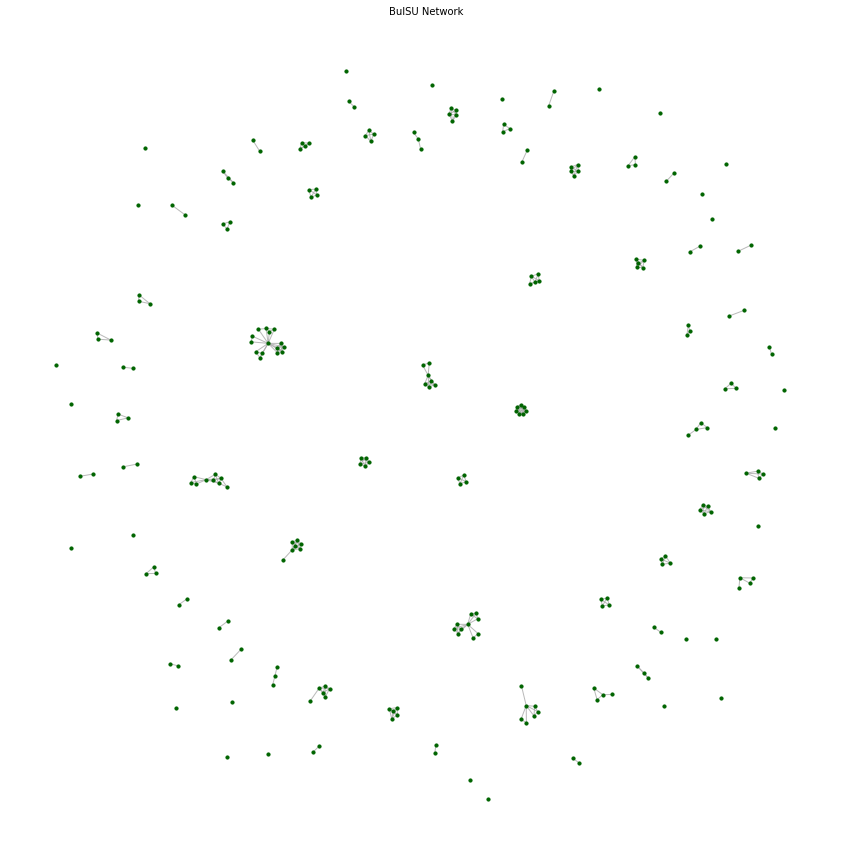

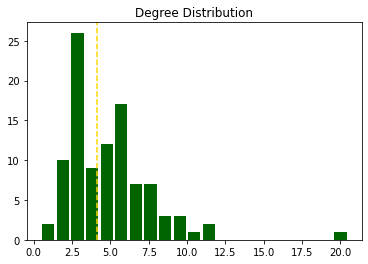

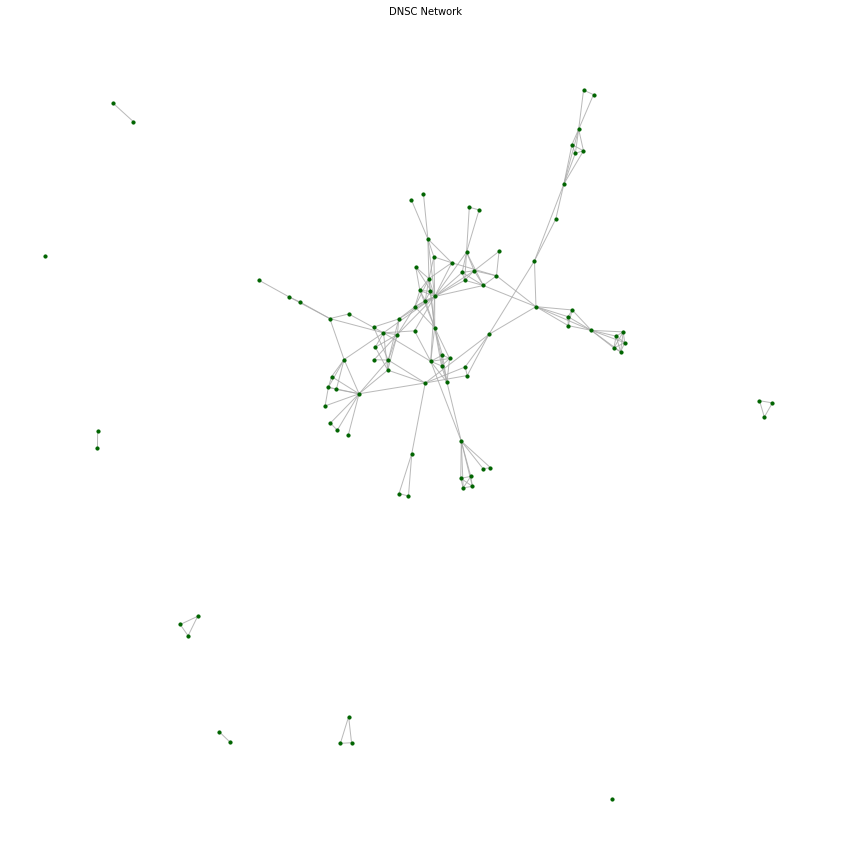

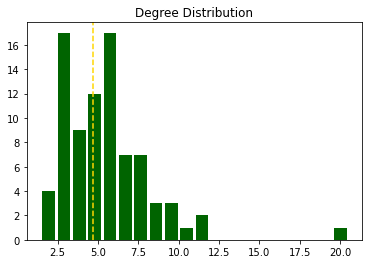

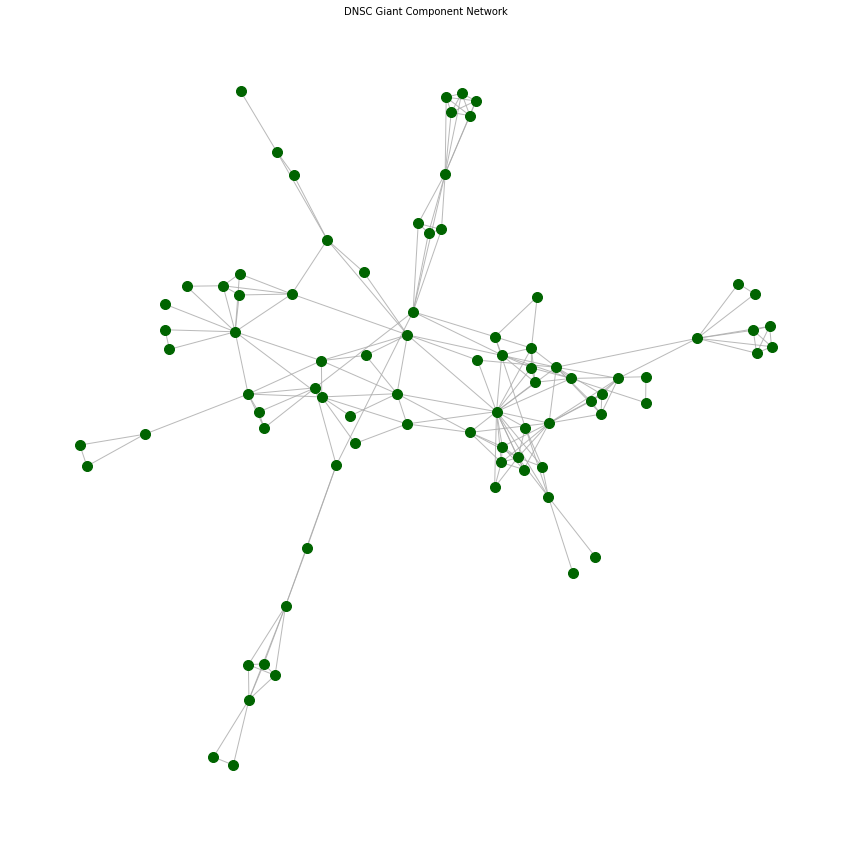

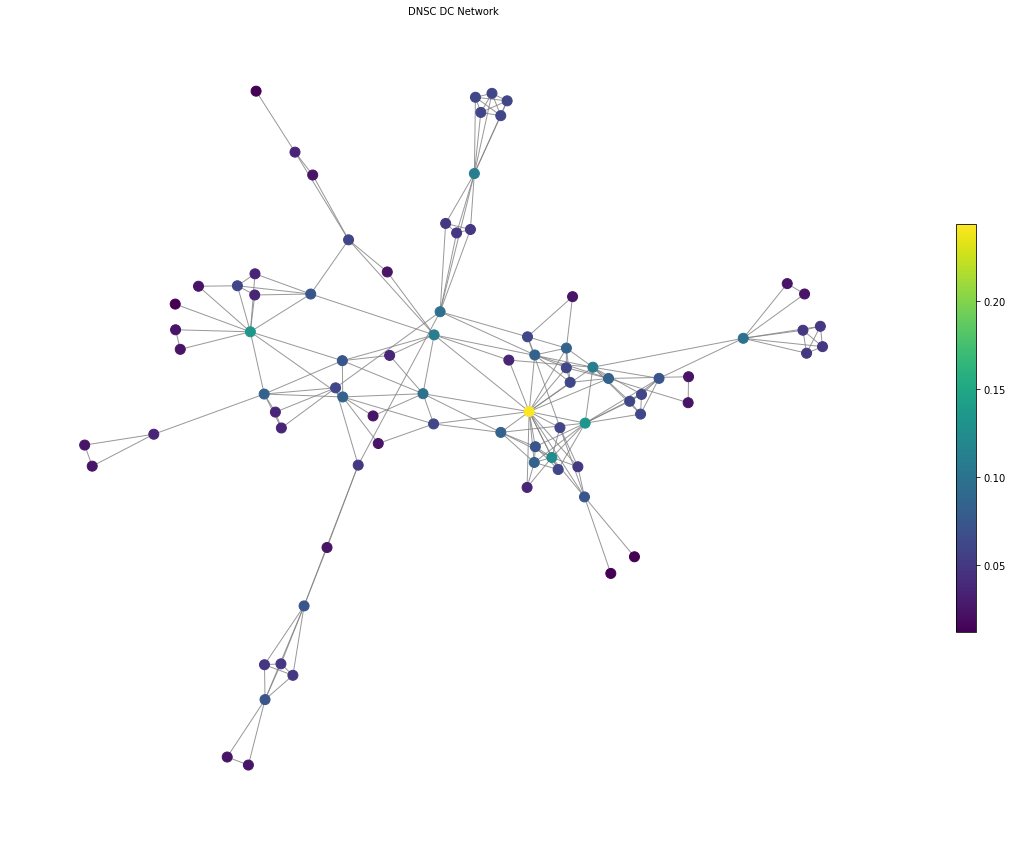

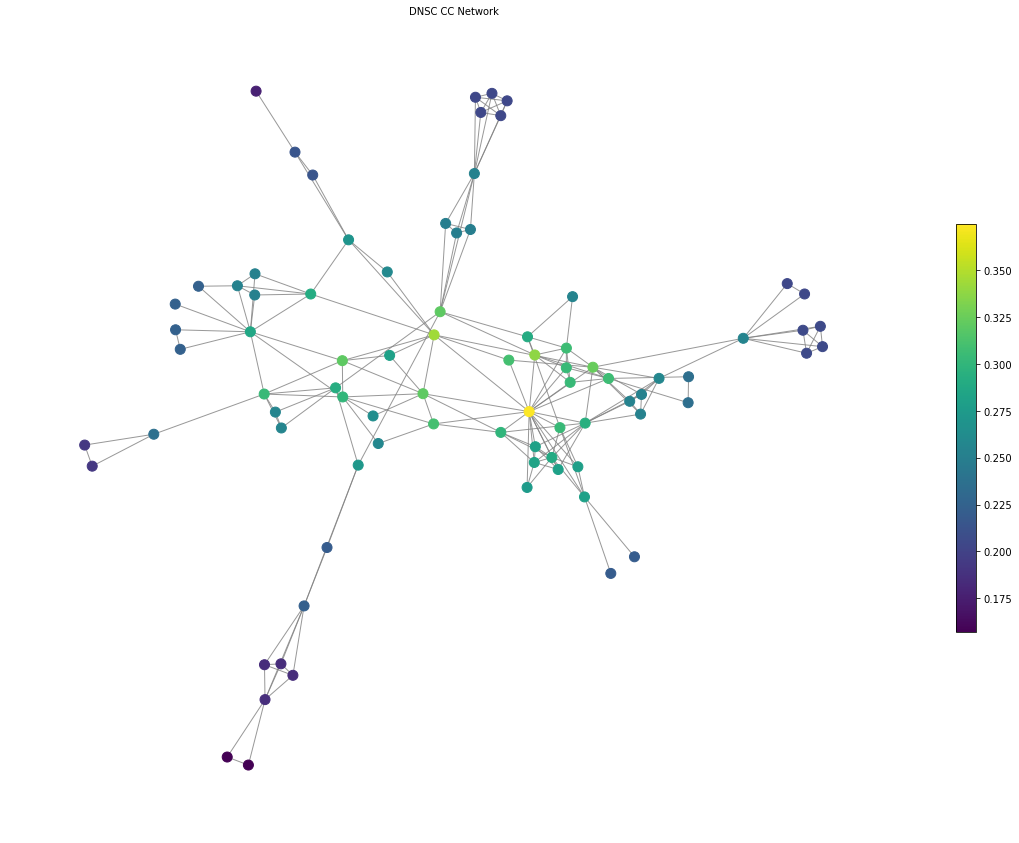

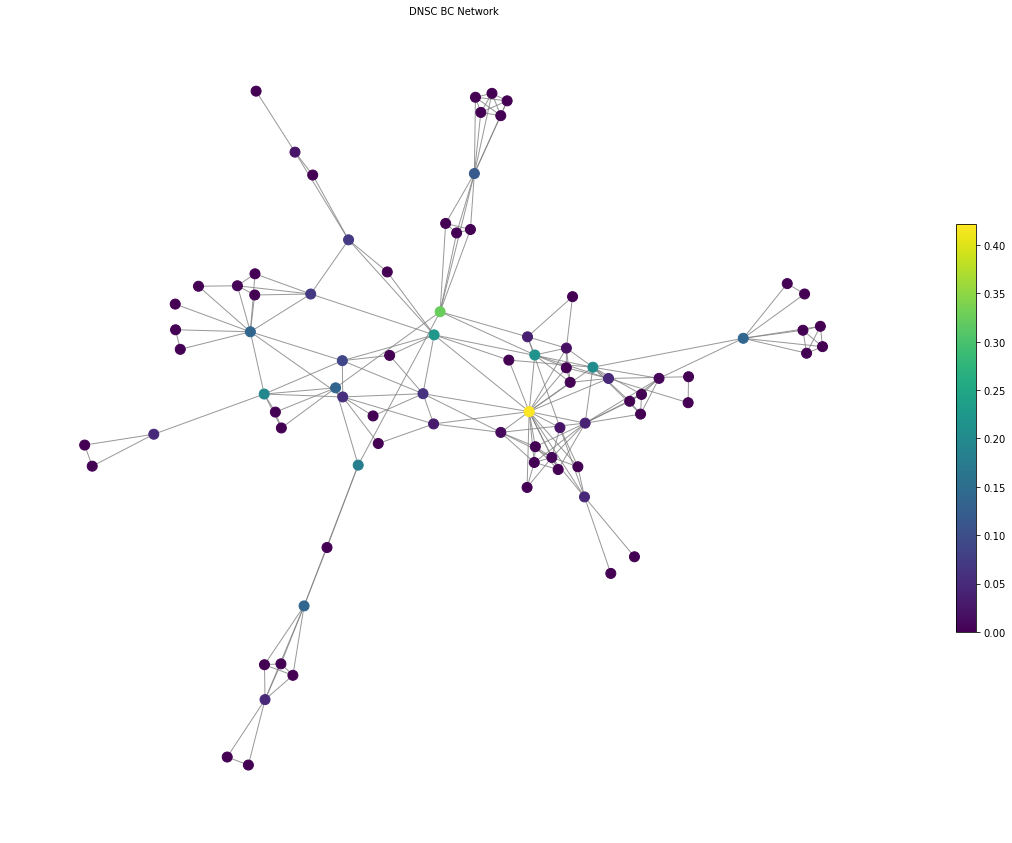

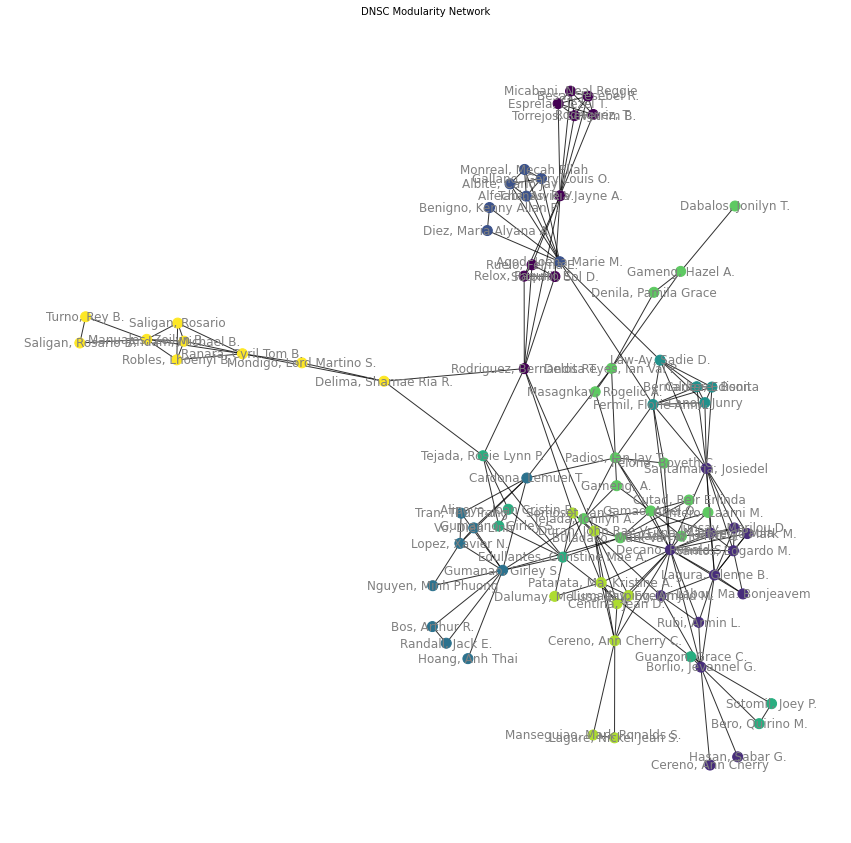

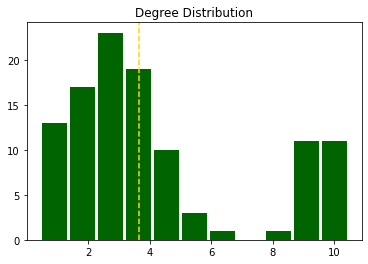

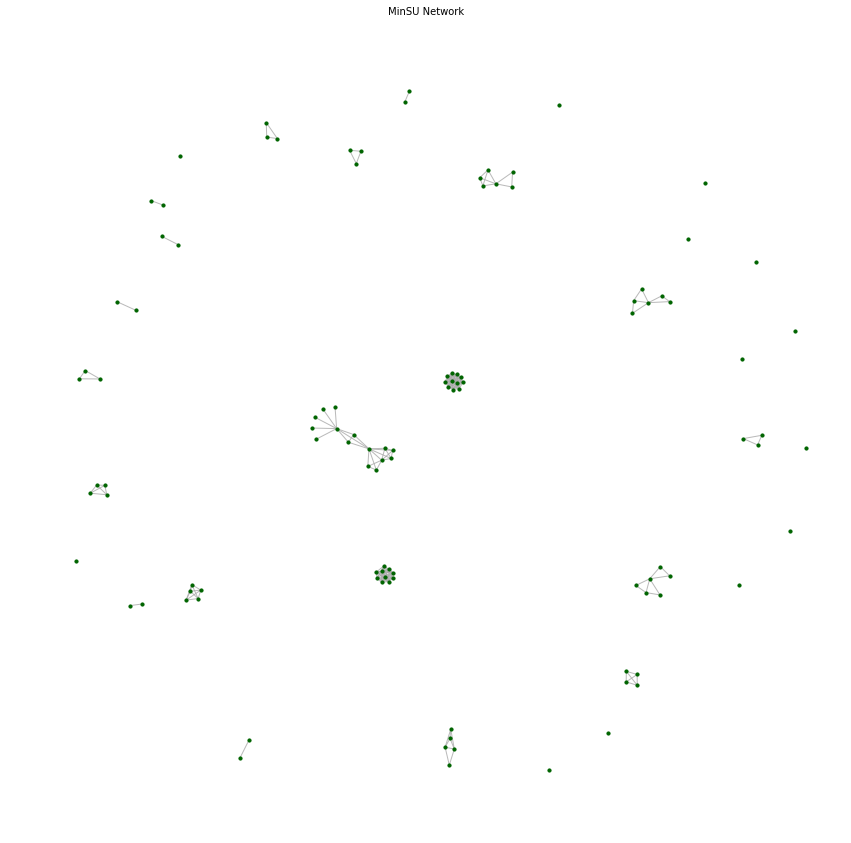

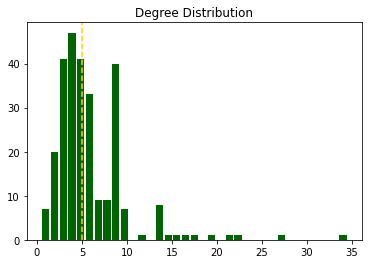

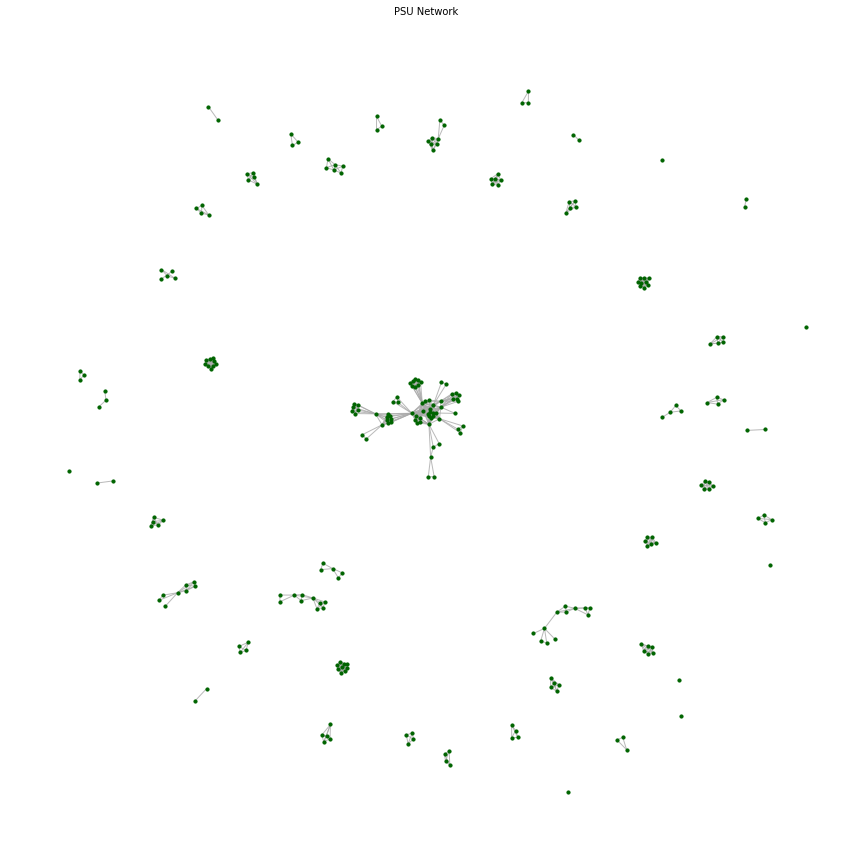

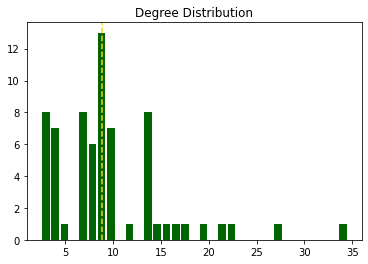

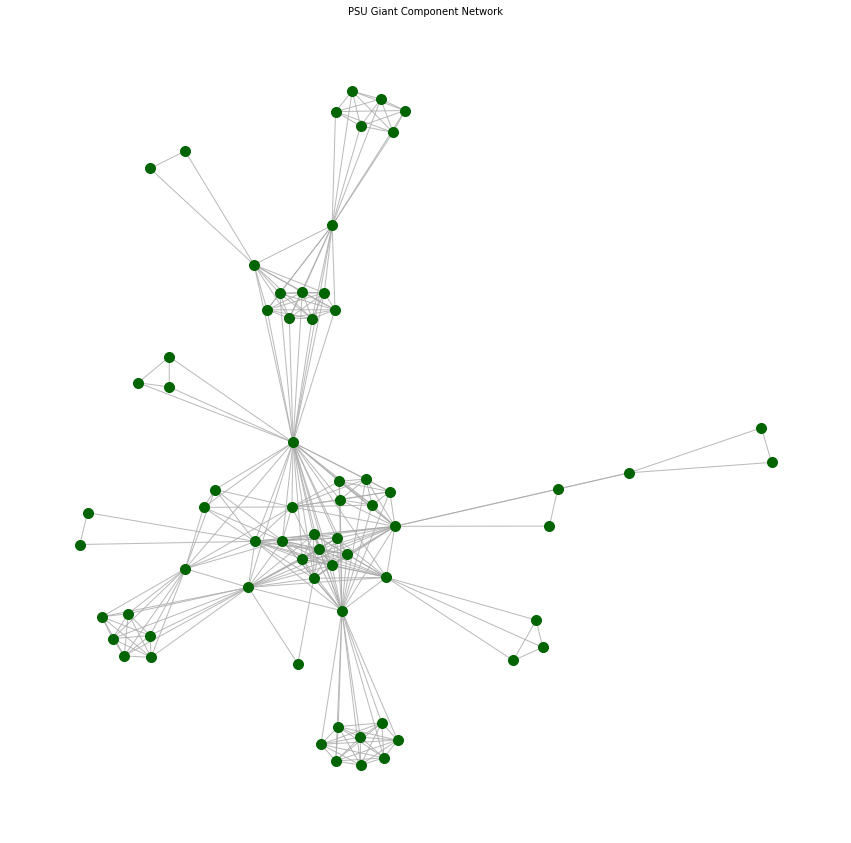

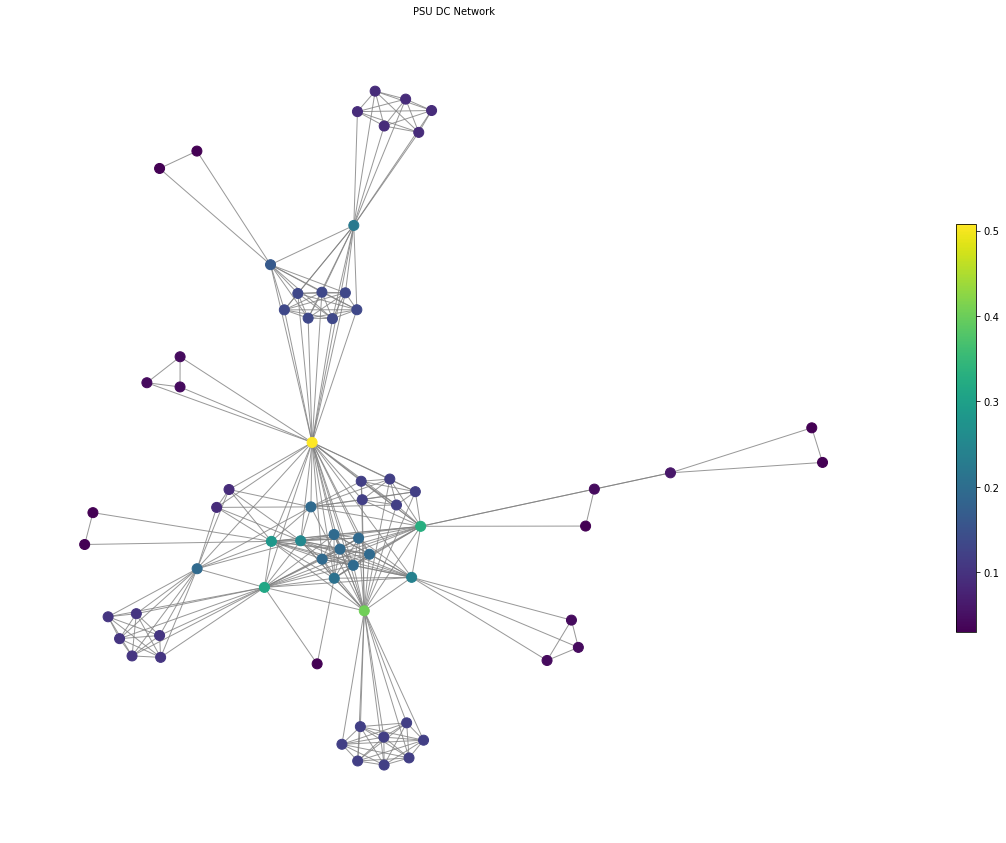

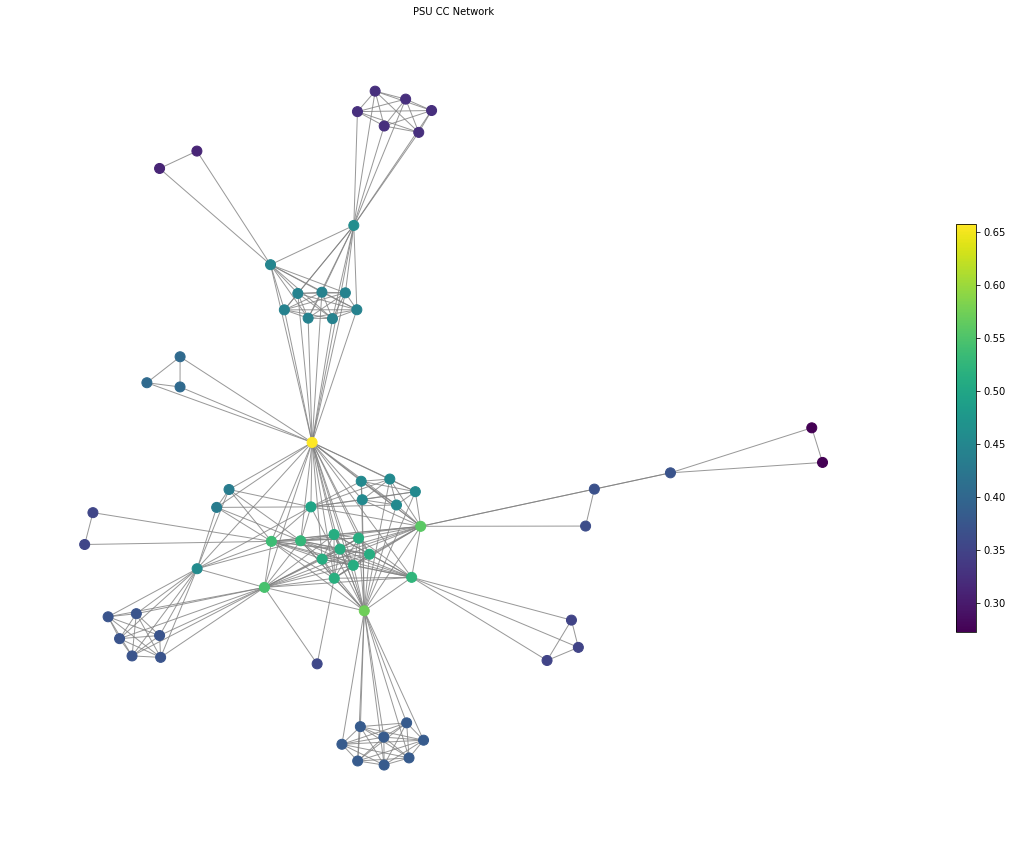

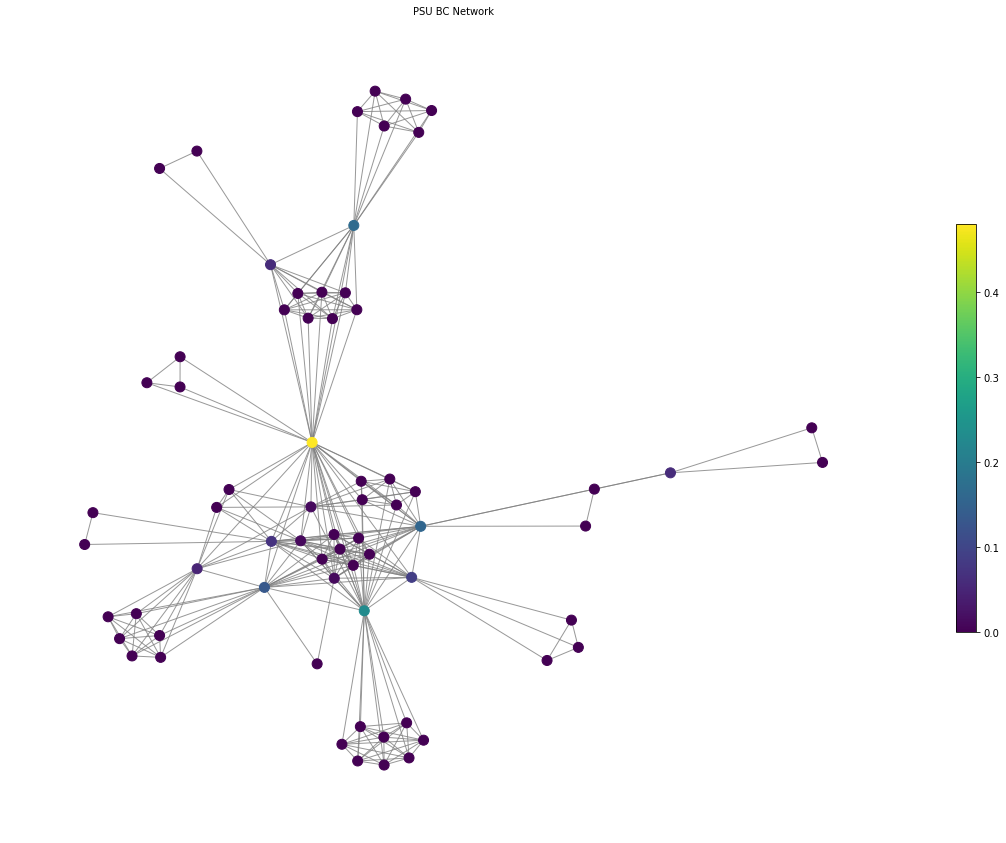

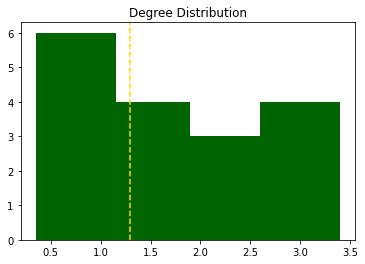

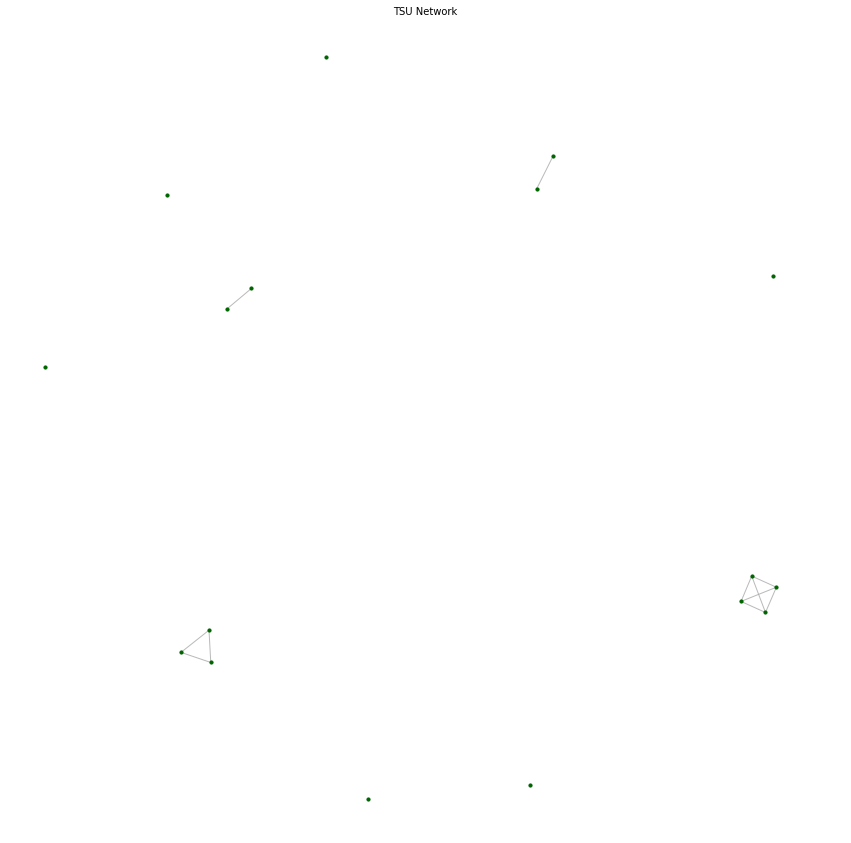

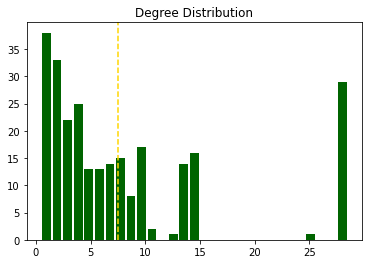

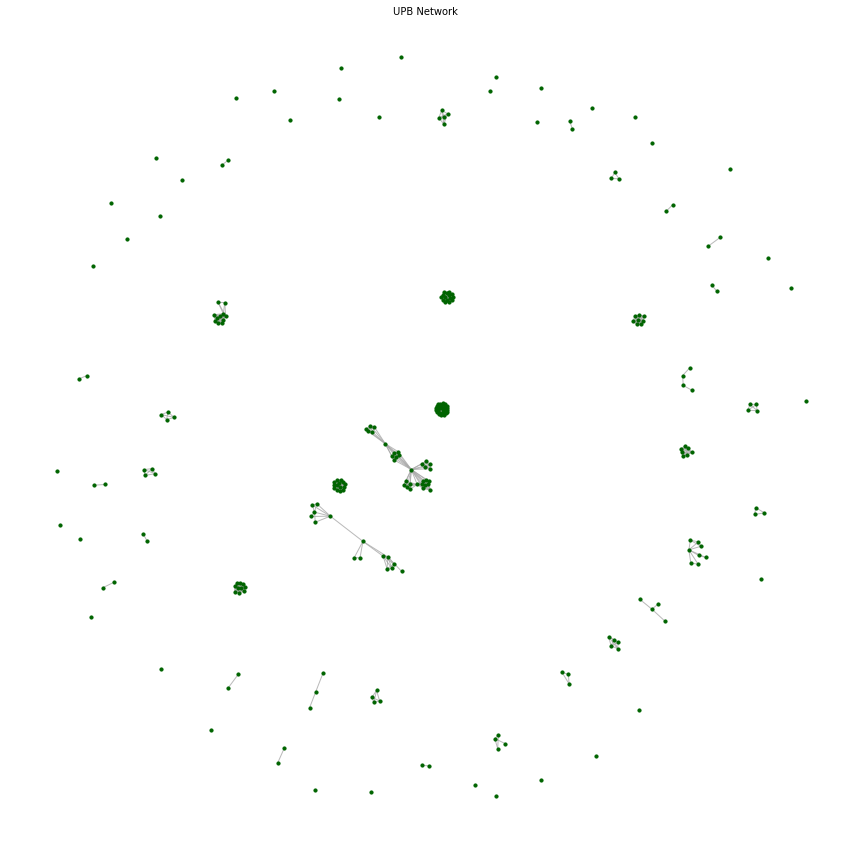

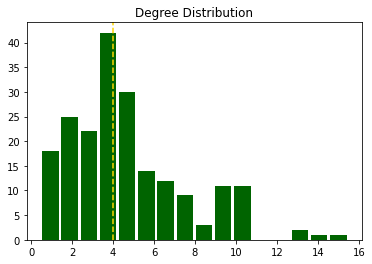

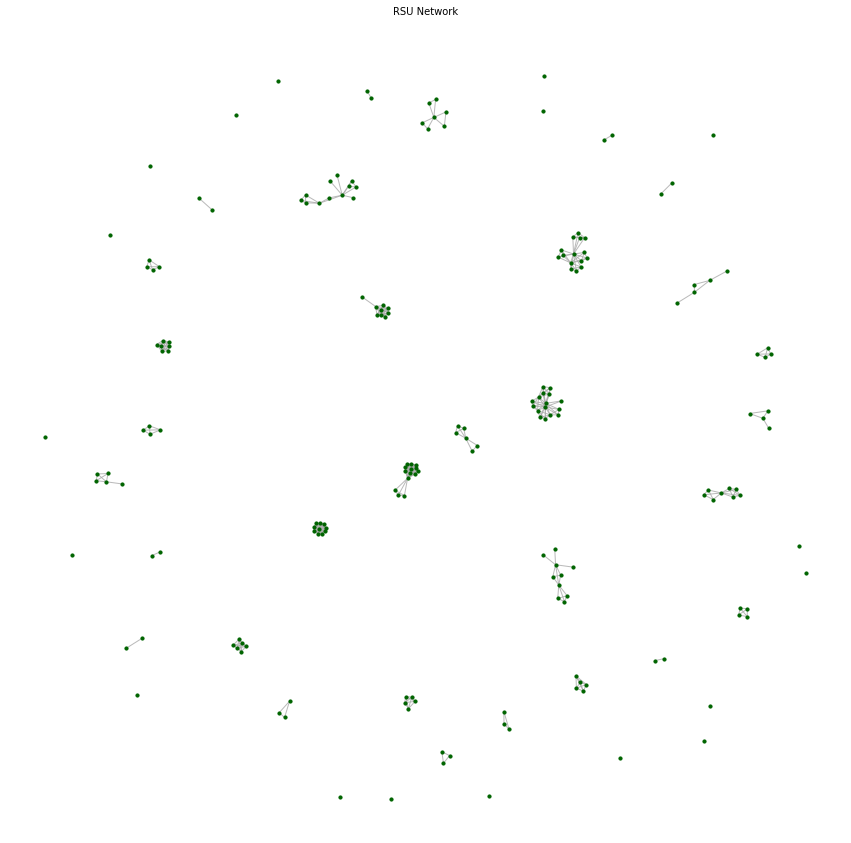

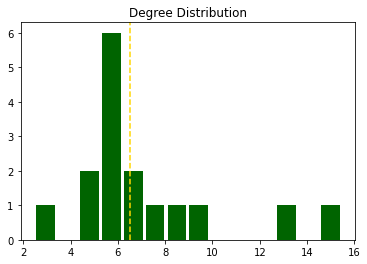

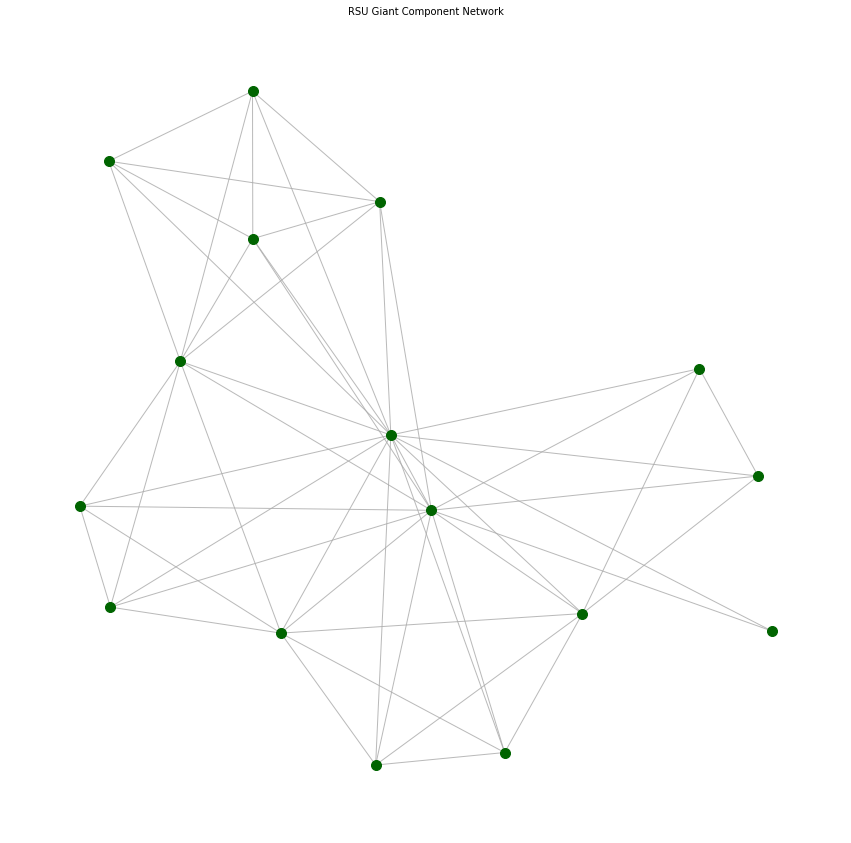

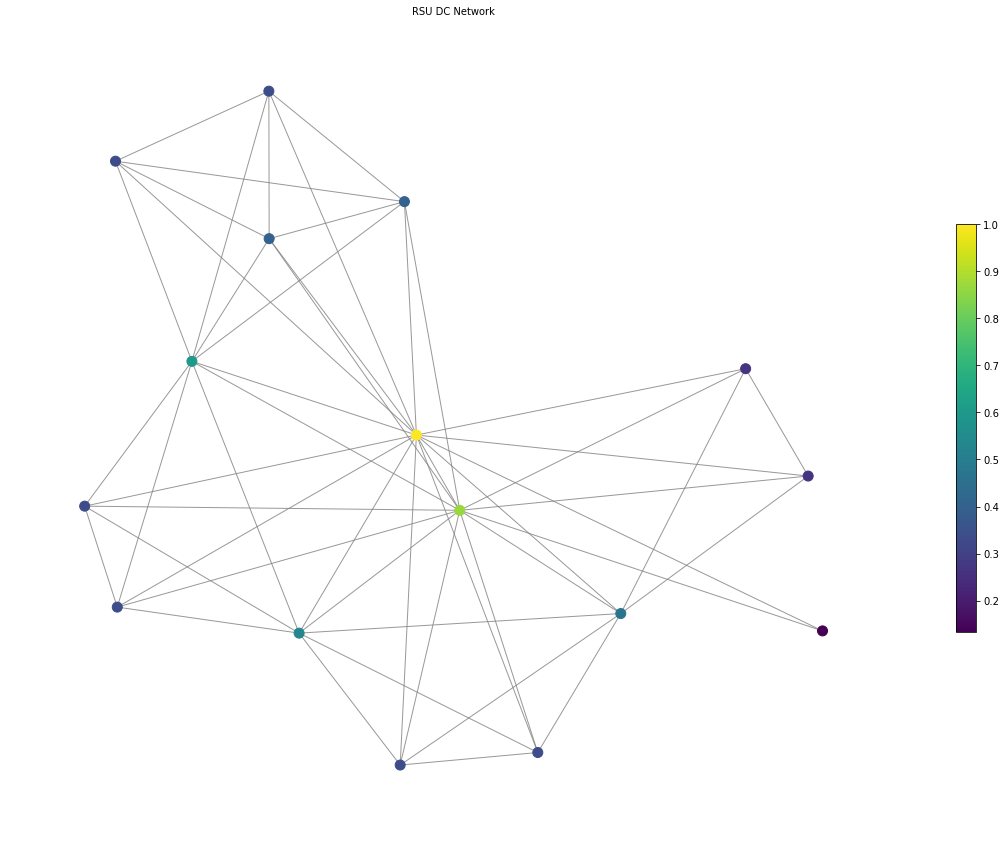

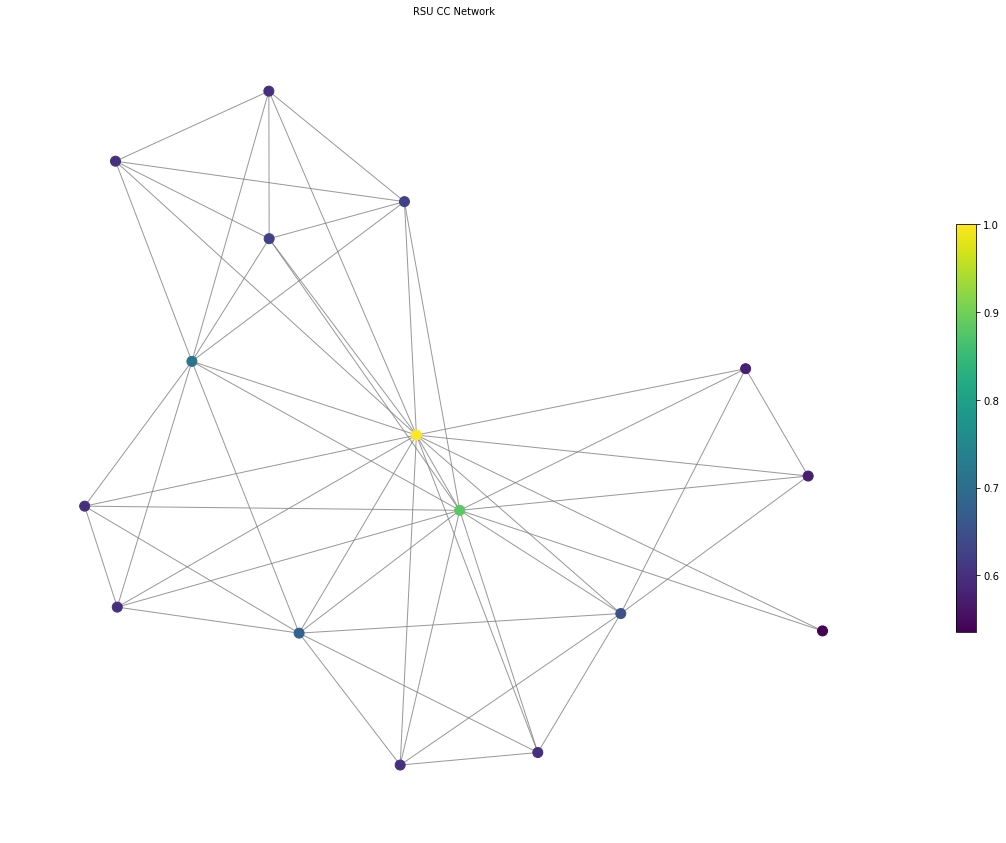

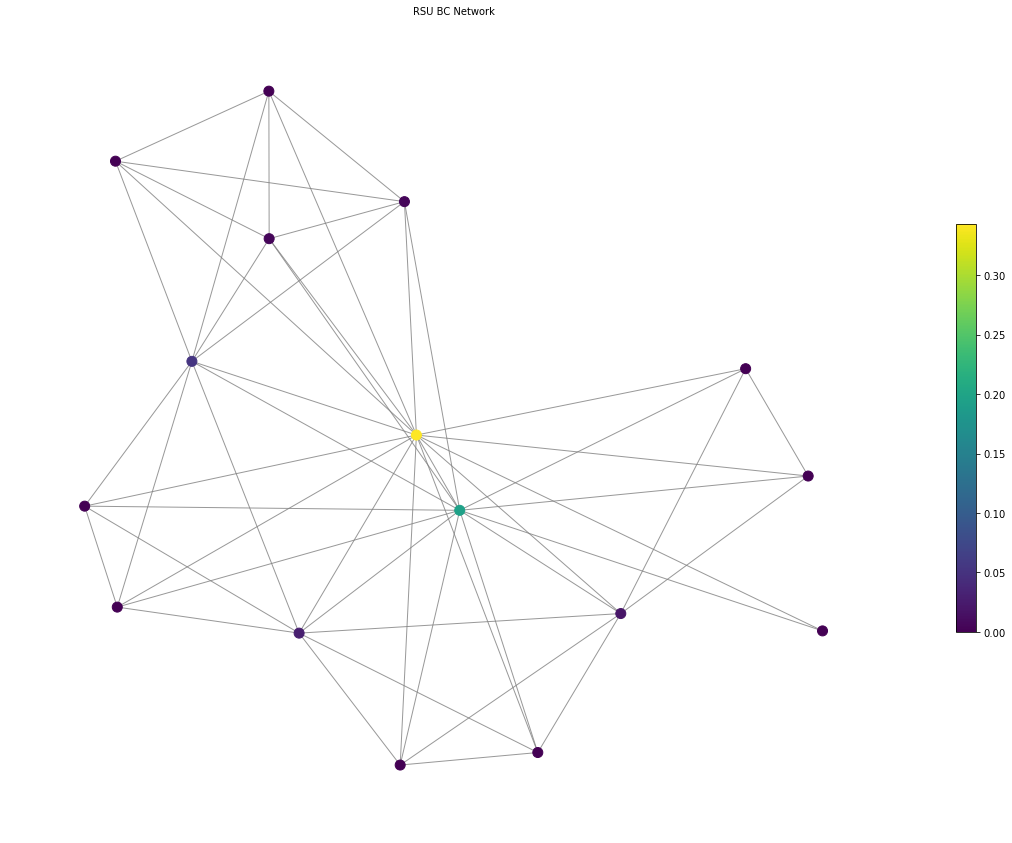

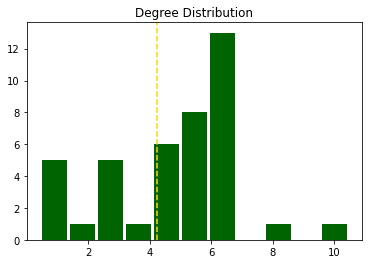

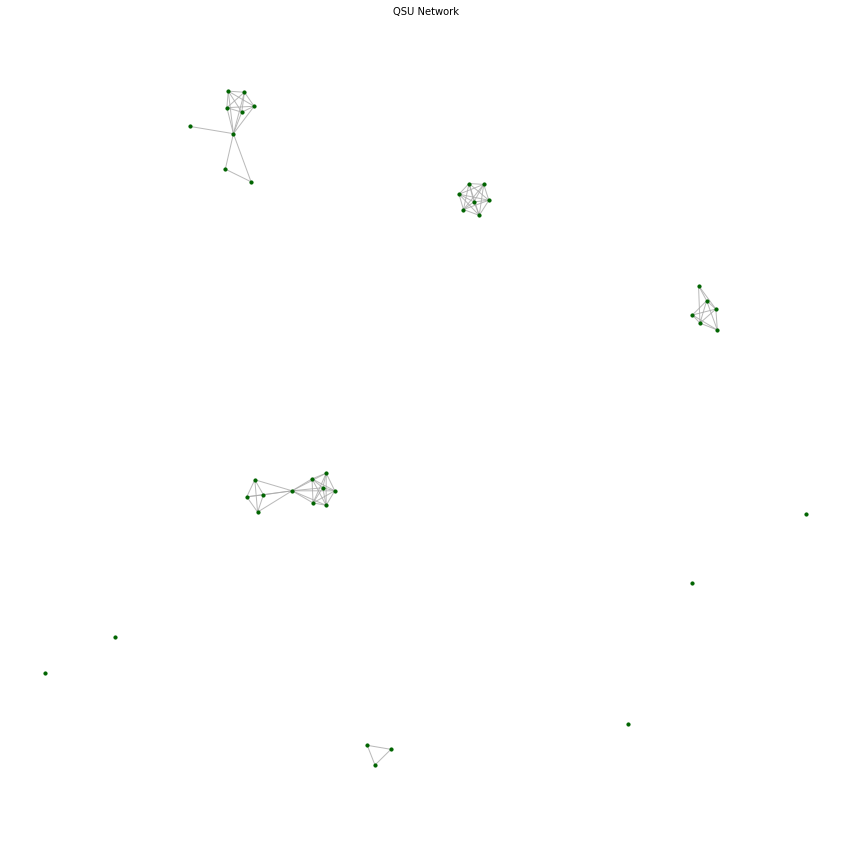

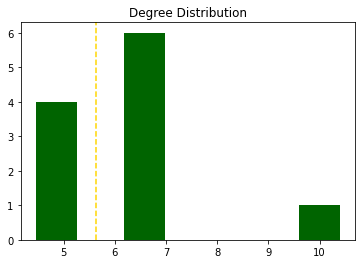

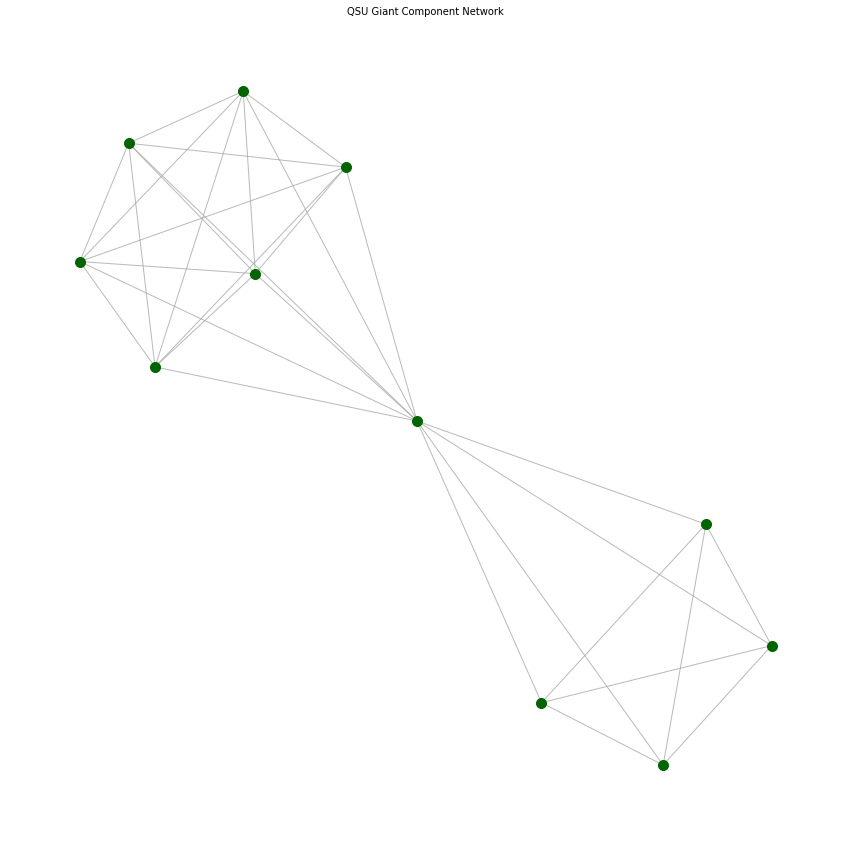

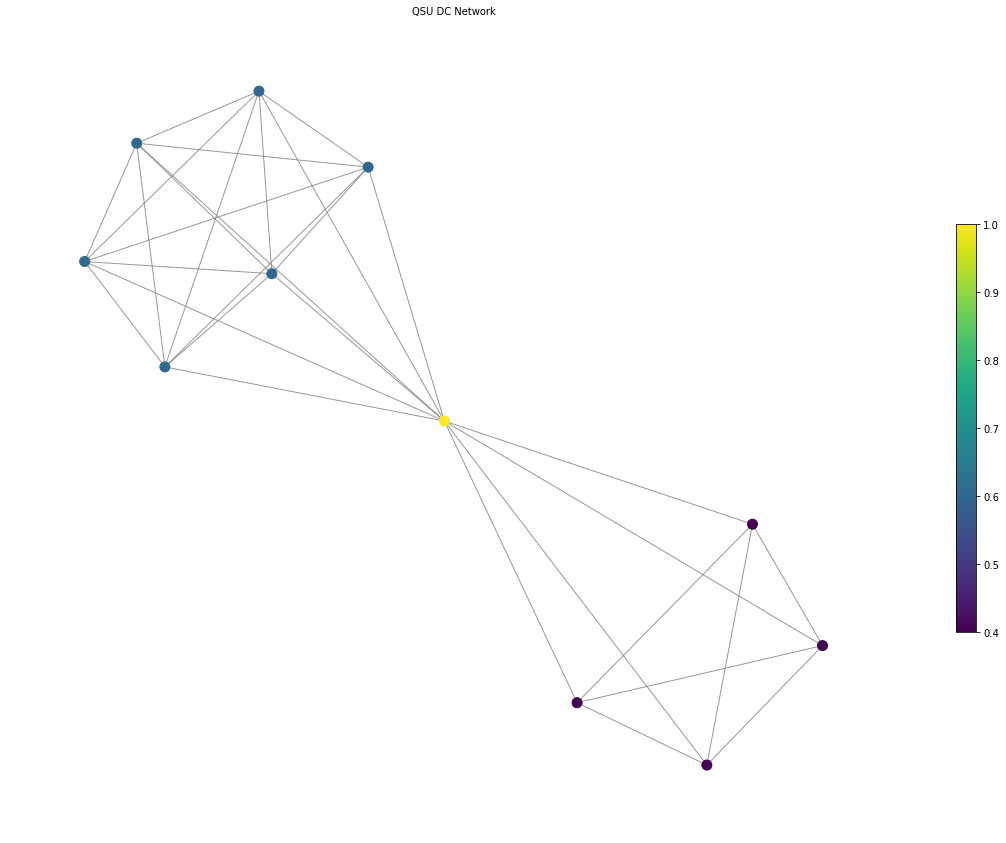

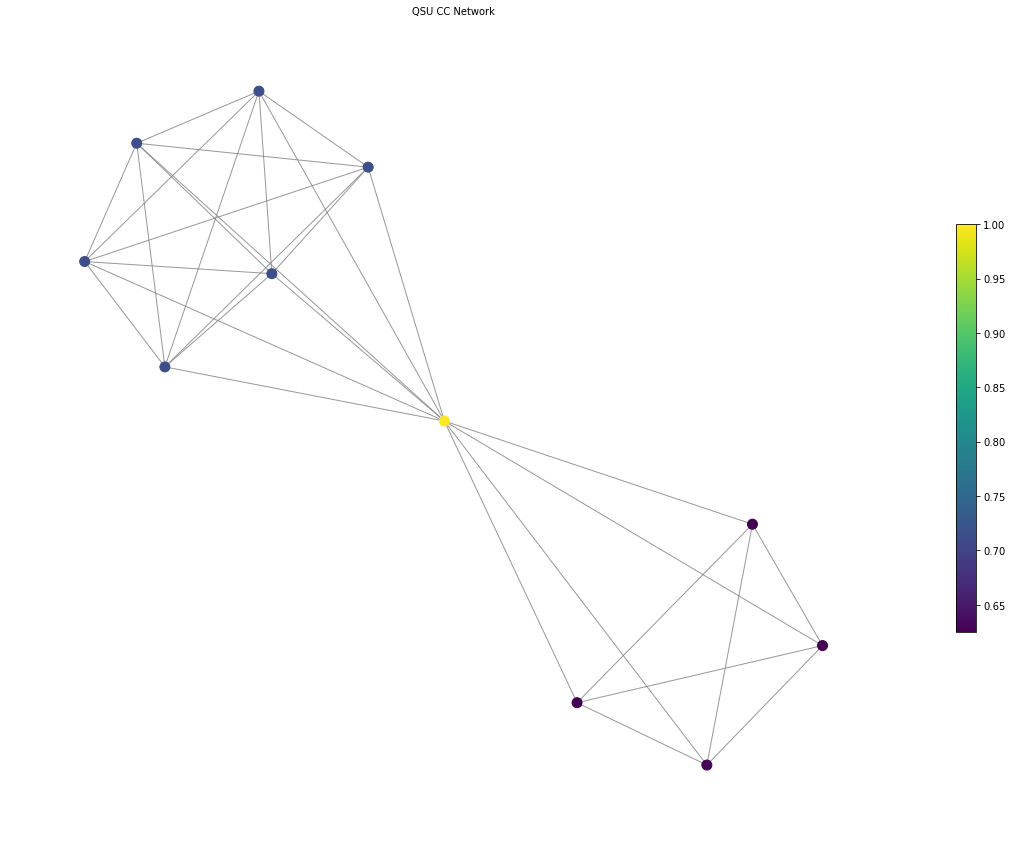

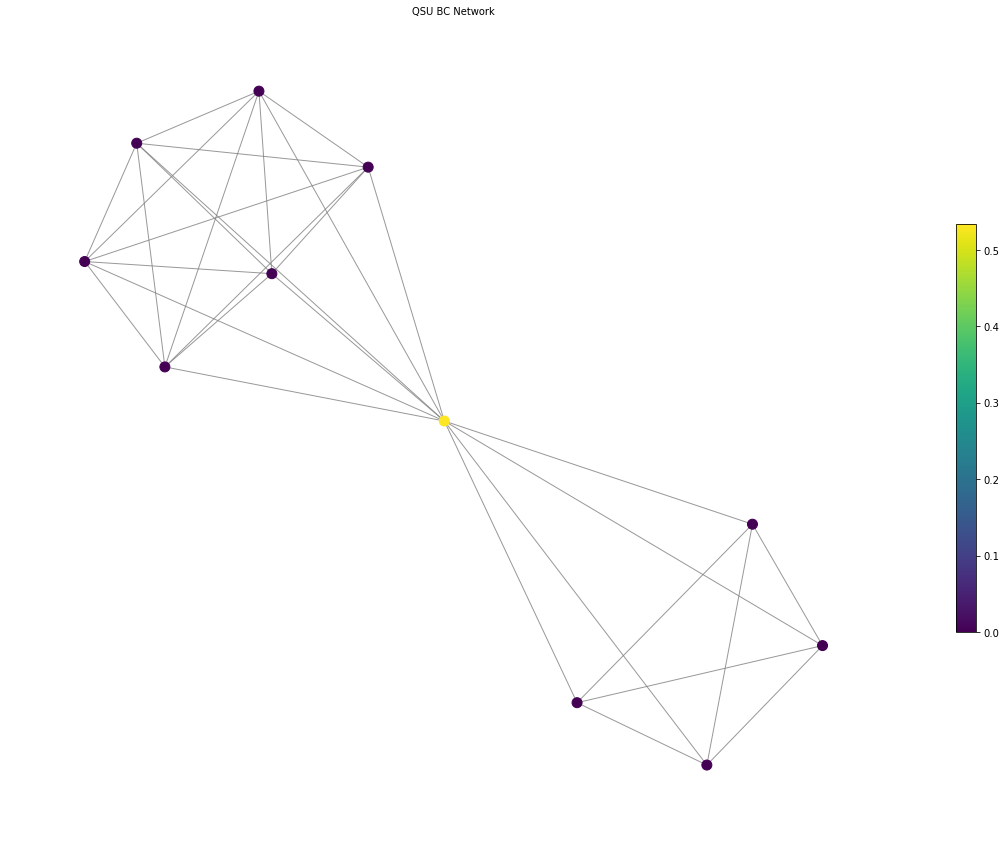

In [19]:
#plot and save figures for individual SUCs

for suc in suc_list:
    sucs = df_rp[df_rp['University (Full Name)'] == suc[0]]
    suc_authors = sucs['Author'].copy().str.split(';')

    edges, nodes = take_edges(suc_authors)

    network = nx.Graph()
    
    for i in edges:
        network.add_edge(i[0], i[1])
    
    for i in nodes:
        network.add_node(i)
    
    network_plots(network, school=suc[1])

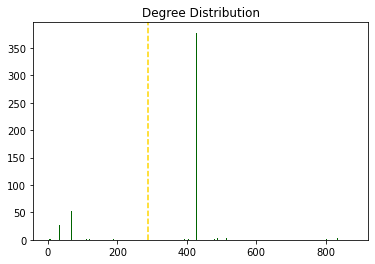

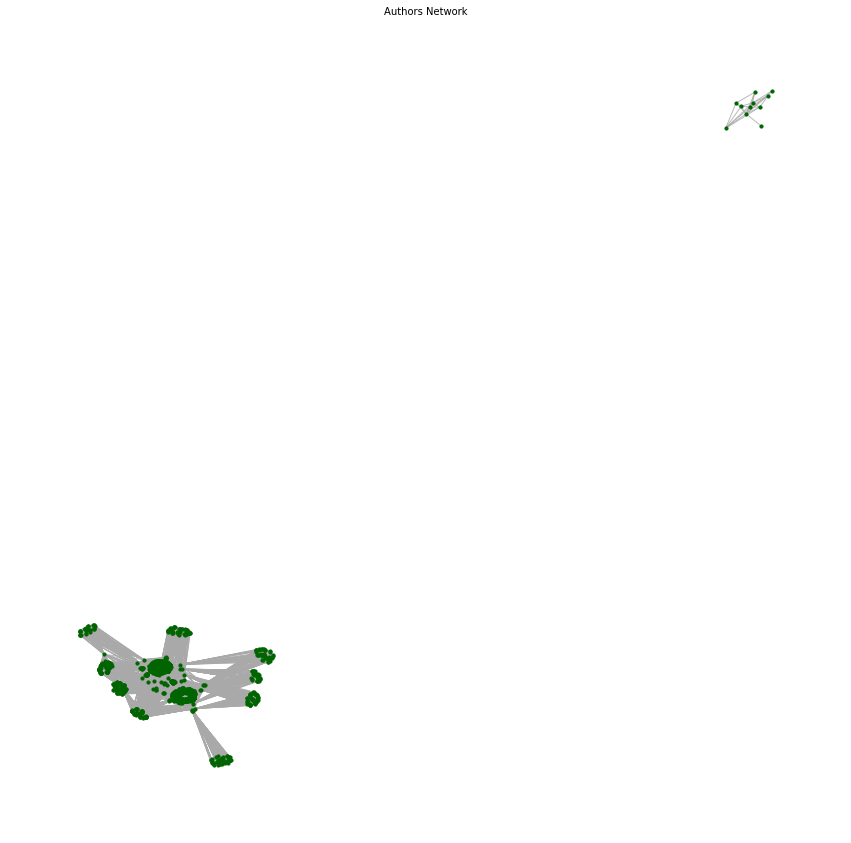

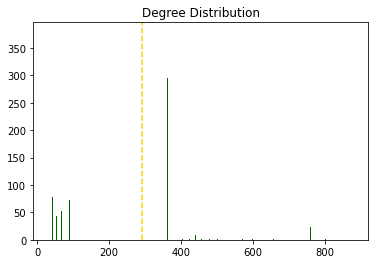

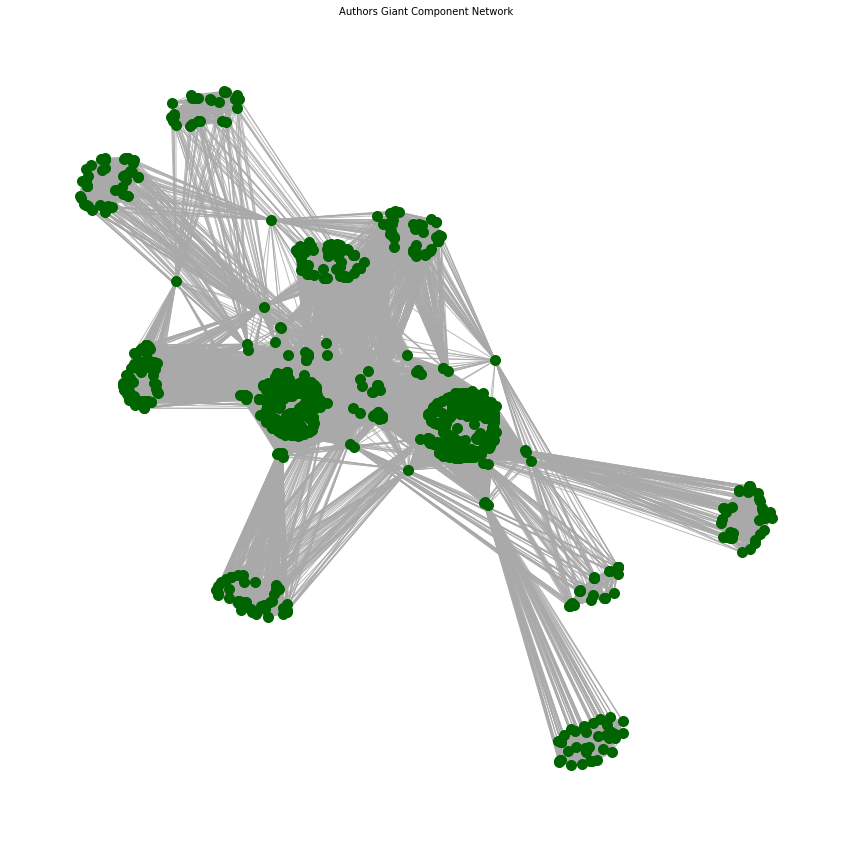

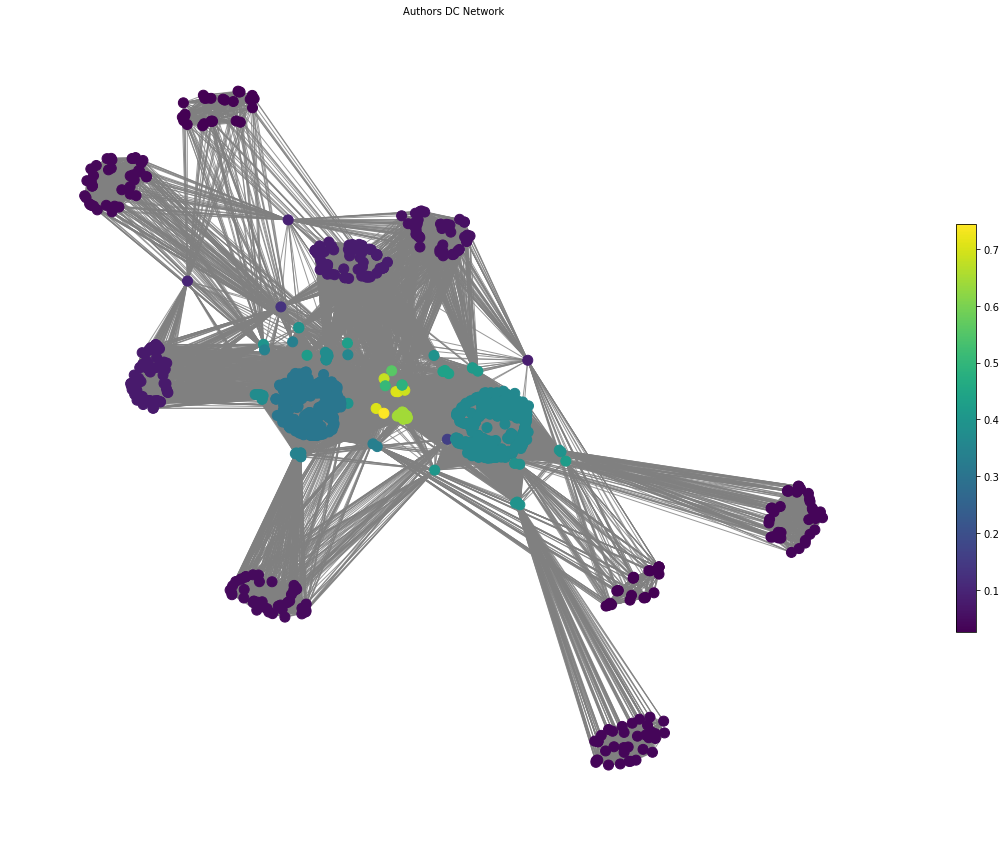

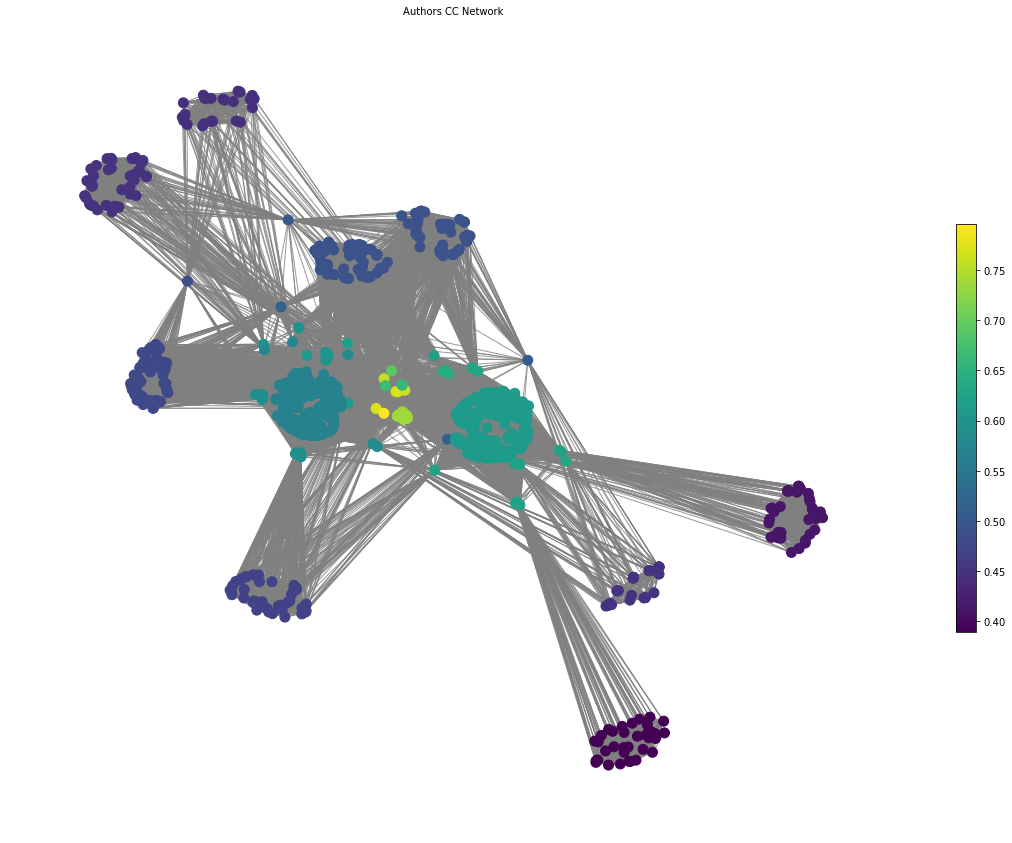

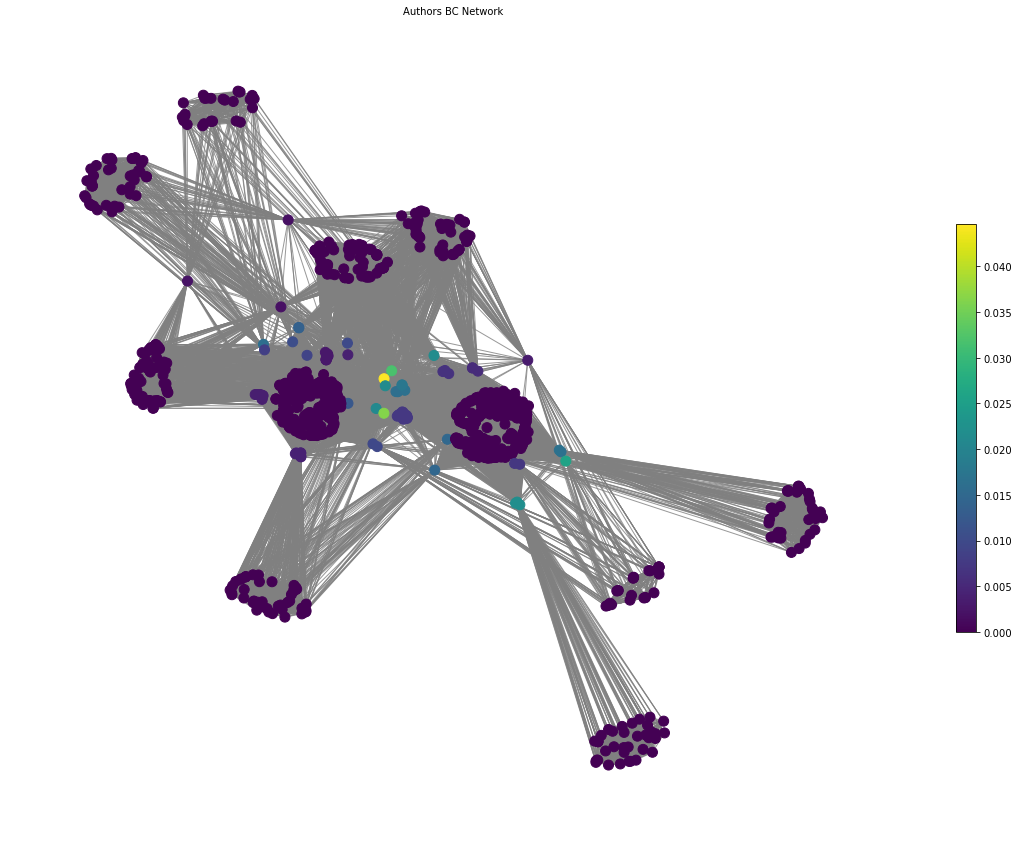

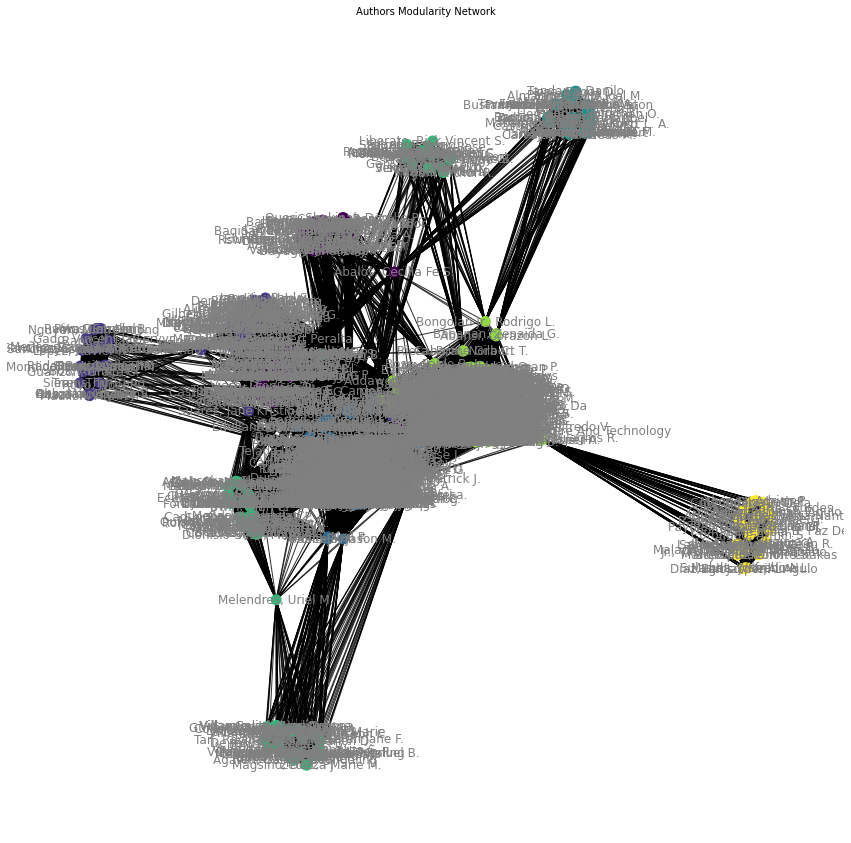

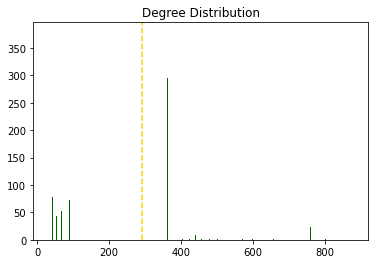

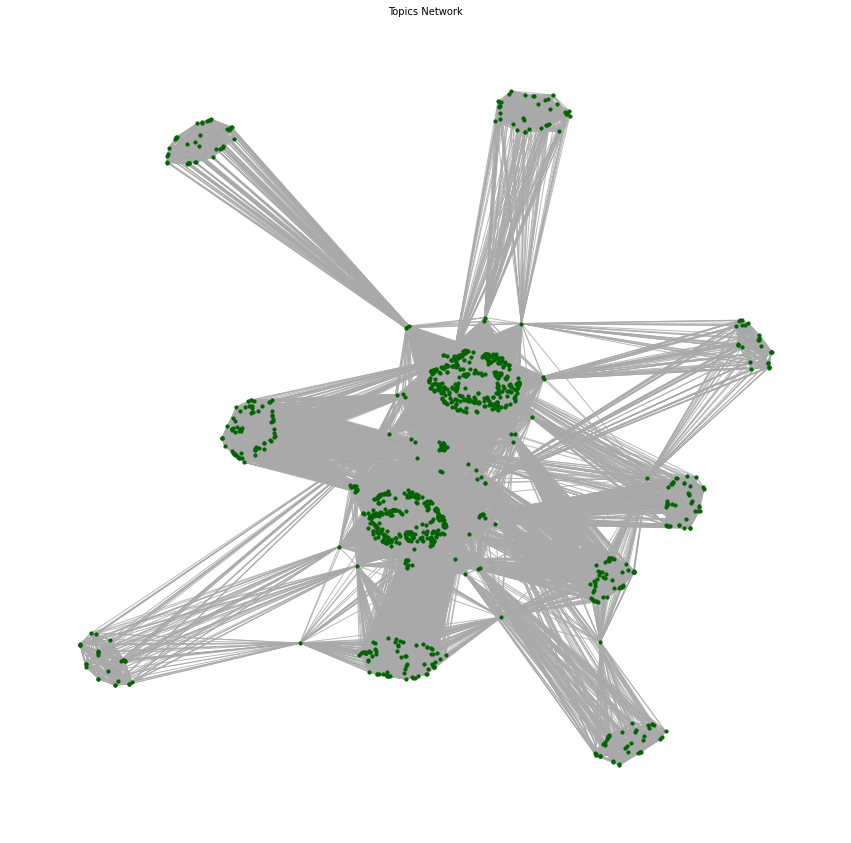

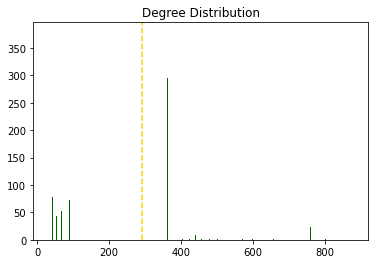

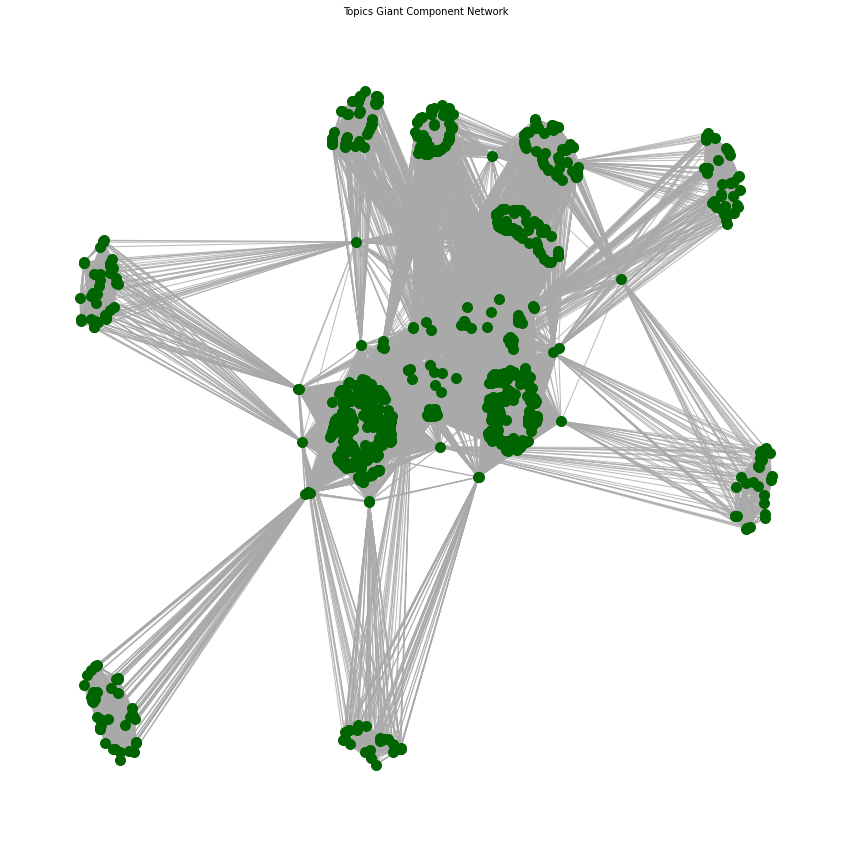

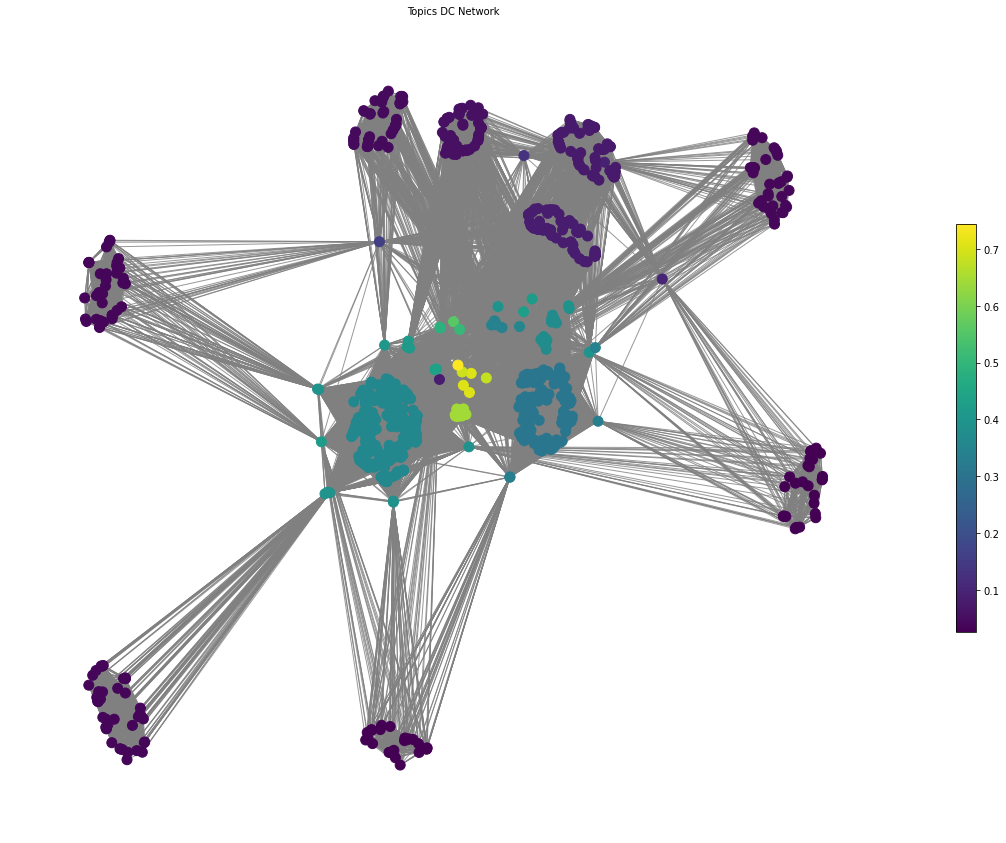

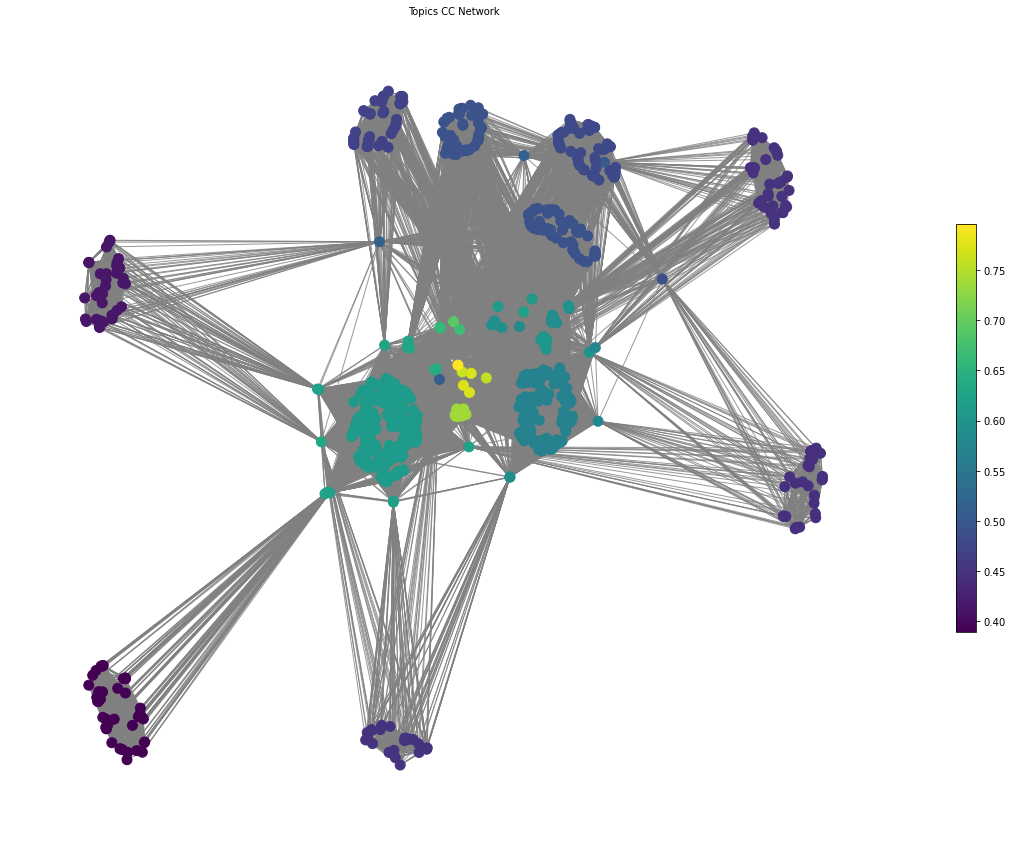

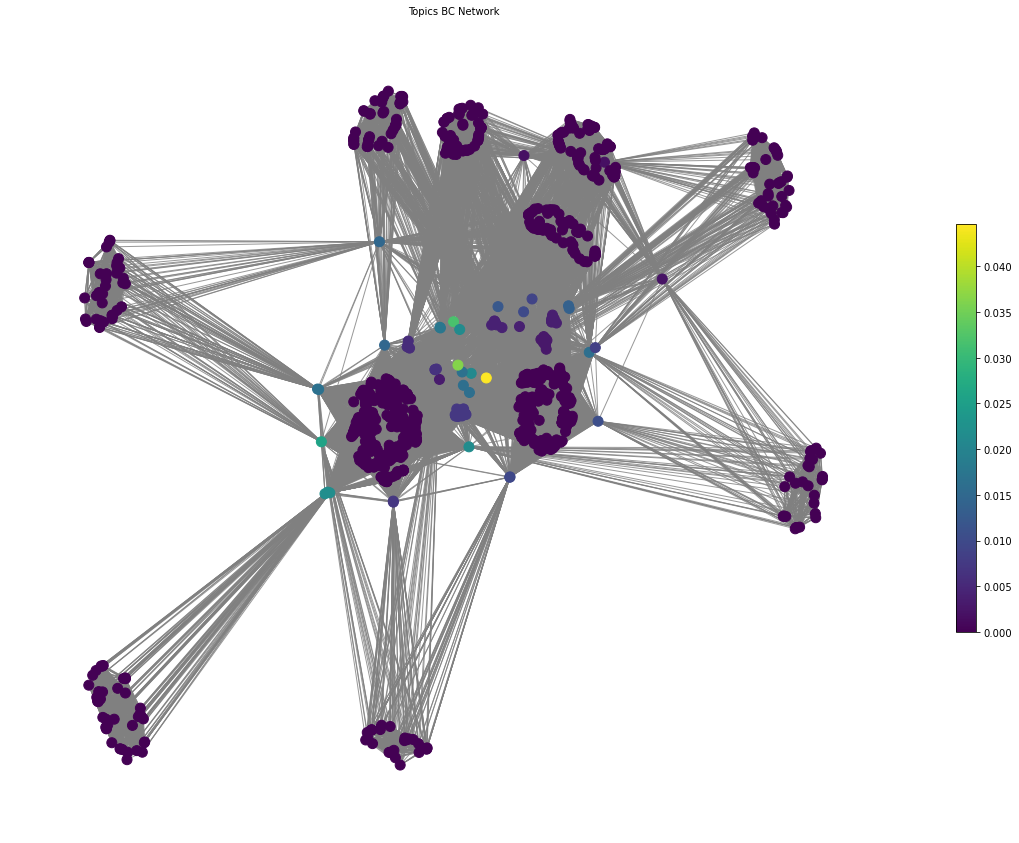

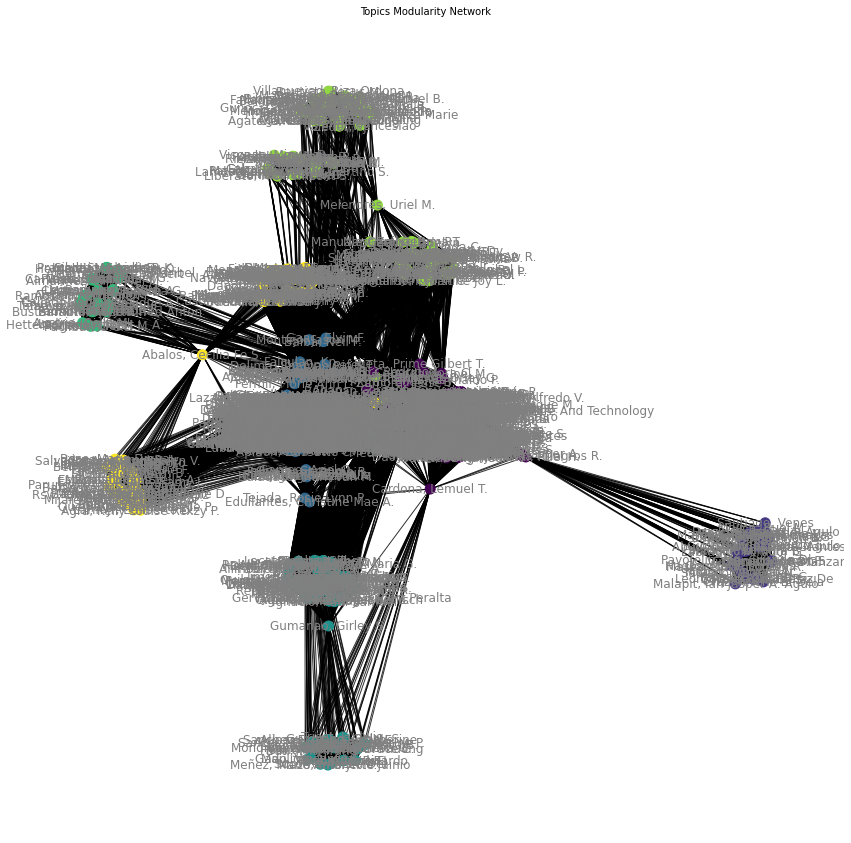

In [20]:
#plot and save figures for author-topic network

bipart_network_plots(A, school='Authors')
bipart_network_plots(T, school='Topics')